<div style="width:100%; height:140px">
    <img src="https://www.kuleuven.be/internationaal/thinktank/fotos-en-logos/ku-leuven-logo.png/image_preview" width = 300px, heigh = auto align=left>
</div>


KUL H02A5a Computer Vision: Group Assignment 2
---------------------------------------------------------------
Student numbers: <span style="color:red">r0708518, r0927391, r0925509, r0924356, r0912639</span>.

# 1. Introduction and overview
This assignment consists of *three main parts*:
* Image classification (Section 2)
* Semantic segmentation (Section 3)
* Adversarial attacks (Section 4)

In the first part, we train an end-to-end neural network for image classification. In the second part, we do the same for semantic segmentation. In the third part, we try to find and exploit the weaknesses of our classification and/or segmentation network. Finally, we reflect and produce an overall discussion with links to the lectures and "real world" computer vision (Section 5).

In two appendices, we provide an in-depth analysis of the architectures considered and how we trained them. In Appendix A, we provide this discussion for the classification models, while the segmentation models are discussed in Appendix B.

## 1.1 Deep learning
We start by loading the required packages for our notebook. We rely on [Tensorflow](https://www.tensorflow.org/) to build our deep learning architectures. A crash course on Tensorflow can be found [here](https://colab.research.google.com/drive/1UCJt8EYjlzCs1H1d1X0iDGYJsHKwu-NO).

In [1]:
# Default packages
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import cv2
from PIL import Image
from tqdm.notebook import tqdm
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
# Deep learning specific packages
import tensorflow as tf
from keras.models import *
from keras.layers import *
from keras.optimizers import *

from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator
from keras.backend import argmax
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
from keras import backend as keras
import keras.losses
from keras import regularizers #fixing overfitting with L2 regularization
import keras.backend as K
from keras.preprocessing.image import *

from skimage.transform import resize
from sklearn.model_selection import train_test_split

import gc
!pip install pickle5
import pickle5 as pickle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.4/256.4 kB 9.4 MB/s eta 0:00:00


In [3]:
# Have to install separate packages for the segmentation models:
!pip install -U -q segmentation-models
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models
from segmentation_models import Unet
from segmentation_models.utils import set_trainable

Segmentation Models: using `tf.keras` framework.


Since training deep learning models is tedious and computationally expensive, we saved the weights of our models to a Kaggle dataset. In case one wants to train the models either way, toggle the next boolean.

In [4]:
TRAIN_MODELS = False
SAVE_LOCATION = "/kaggle/working/"

## 1.2 PASCAL VOC 2009
For this project, we will consider data from the [PASCAL VOC 2009](http://host.robots.ox.ac.uk/pascal/VOC/voc2009/index.html) dataset. The goal of using this dataset is to recongize objects embedded into realistic scenes, meaning that the images are not preprocessed to pre-segmented objects. Therefore, it is a supervised learning problem where the input data are images and the output data are the labels of the objects that are present in the image. There are twenty different objects present in the dataset:
* Person: person
* Animal: bird, cat, cow, dog, horse, sheep
* Vehicle: aeroplane, bicycle, boat, bus, car, motorbike, train
* Indoor: bottle, chair, dining table, potted plant, sofa, tv/monitor

In this first section, we will consider the **classification** part of the competition, where the goal is to predict the presence/absence of a class in the images of the test set. In the second section, we consider the **segmentation** part of the competition, where the goal is instead to generate pixel-wise segmentations that determine the class of the object visible at each pixel (or whether the pixel is belonging to the background). 

Let us start by loading the data provided by the Kaggle competition.

In [5]:
# Loading the training data
train_df = pd.read_csv('/kaggle/input/kul-h02a5a-computer-vision-ga2-2023/train/train_set.csv', index_col="Id")
labels = train_df.columns[0:20]
labels_str = labels.tolist()
train_df["img"] = [np.load('/kaggle/input/kul-h02a5a-computer-vision-ga2-2023/train/img/train_{}.npy'.format(idx)) for idx, _ in train_df.iterrows()]
train_df["seg"] = [np.load('/kaggle/input/kul-h02a5a-computer-vision-ga2-2023/train/seg/train_{}.npy'.format(idx)) for idx, _ in train_df.iterrows()]
print("The training set contains {} examples.".format(len(train_df)))

The training set contains 749 examples.


In [6]:
# Loading the test data
test_df = pd.read_csv('/kaggle/input/kul-h02a5a-computer-vision-ga2-2023/test/test_set.csv', index_col="Id")
test_df["img"] = [np.load('/kaggle/input/kul-h02a5a-computer-vision-ga2-2023/test/img/test_{}.npy'.format(idx)) for idx, _ in test_df.iterrows()]
test_df["seg"] = [-1 * np.ones(img.shape[:2], dtype=np.int8) for img in test_df["img"]]
print("The test set contains {} examples.".format(len(test_df)))

The test set contains 750 examples.


Before we jump into the problem it is advised to consider the provided data and their meaning. The first row of the dataset is shown below:

In [7]:
train_df.head(1)

aeroplane  bicycle  bird  boat  bottle  bus  car  cat  chair  cow  ...  \
Id                                                                     ...   
0           0        0     0     0       0    0    0    0      0    1  ...   

    horse  motorbike  person  pottedplant  sheep  sofa  train  tvmonitor  \
Id                                                                         
0       0          0       0            0      0     0      0          0   

                                                  img  \
Id                                                      
0   [[[10, 8, 13], [16, 14, 19], [17, 14, 21], [19...   

                                                  seg  
Id                                                     
0   [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  

[1 rows x 22 columns]

 The given dataframes contain 22 columns, where the first 20 correspond to the classes that are present in the Pascal VOC dataset. A value of $0$ denotes that the corresponding object is not present in the image, while a value of $1$ indicates that the object is present in the image. We define a colormap based on the labels of the Pascal dataset:

In [8]:
# Get discrete colorbar
cmap = plt.cm.viridis
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
pascal_cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
pascal_norm = mpl.colors.BoundaryNorm(np.arange(0.5,20+1), cmap.N) 

### 1.2.1 Exploring the data

We first start off by exploring the provided datasets. Let us first look at the segmentation part. The remaining two columns of the dataset provide the image and the segmentations. The segmentations have the same 2D shape as the images, but have only one channel, of which the value determines the class to which the pixel belongs, with 0 indicating the background. We demonstrate this with an example:

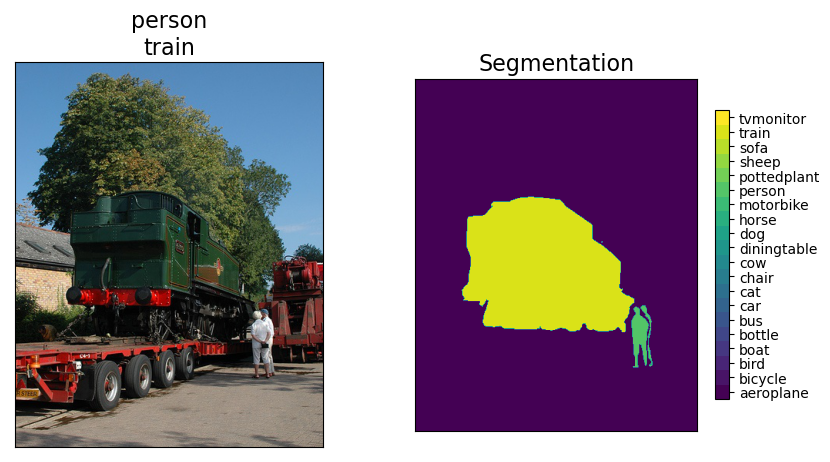

In [9]:
# Get an example image
ind = 7
example_img = train_df.loc[ind]["img"]
example_seg = train_df.loc[ind]["seg"]
# Show the image and the segmentation
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax1, ax2 = axs

# Show the picture
ax1.imshow(example_img)
ax1.set_title("\n".join(f"{label}" for label in labels if train_df.iloc[ind][label] == 1), fontsize=16)

# Show segmentation with colorbar
im = ax2.imshow(example_seg, cmap=pascal_cmap, norm=pascal_norm)
cbar = fig.colorbar(im, ax=ax2, shrink=0.75, ticks=np.linspace(1, 20, 20))
cbar.ax.set_yticklabels(labels)
ax2.set_title("Segmentation", fontsize=16)

# Remove ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

It can also be convenient to see the **class distribution** in the provided dataset. Since images can have several class labels attached to them, as the example above shows, we just count the number of occurences of each class in the provided dataset and divide it by the size of the dataset, to see the percentage of occurence of each label. As the plot shows, there are a lot of images with persons. The other classes are more or less balanced balanced in distribution.

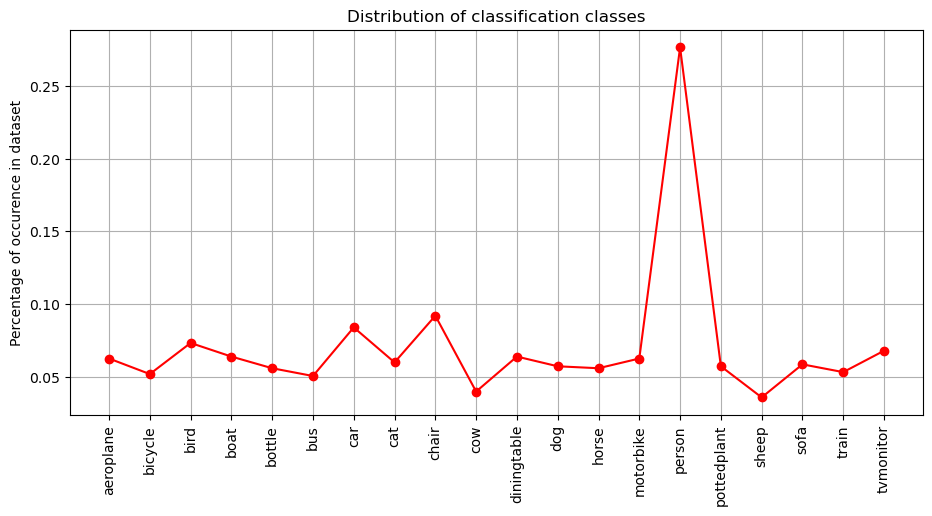

In [10]:
# Get class distributions
class_distr = np.array([np.sum(train_df[lab]) for lab in labels])/len(train_df)
# Plot it
plt.figure(figsize=(11,5))
xt = [i for i in range(len(class_distr))]
plt.plot(xt, class_distr, "-o", color="red")
plt.xticks(xt, labels=labels, rotation=90)
plt.ylabel("Percentage of occurence in dataset")
plt.title("Distribution of classification classes")
plt.grid()
plt.show()

We now do the same to get the **segmentation distribution**. As the plot shows, the distribution is hugely imbalanced here. Therefore, the challenge in this task is to improve upon a segmentation classifier that always predicts the majority class, as this simple classifier would already have a baseline accuracy of almost 80%.

In [11]:
def counts_seg(df):
    """
    Counts the segmentation pixels in a provided dataframe
    """
    
    # Initialize a counter for each class and total counter
    seg_distr = np.zeros(21)
    total_nb_pixels = 0
    
    # Iterate over segmentation masks
    for seg in df["seg"]:
        # Get the counts of the segmentation pixels:
        unique, counts = np.unique(seg, return_counts=True)
        # Add counts to correct class
        for i, label in enumerate(unique):
            seg_distr[label] += counts[i]
        # Add size of image (pixels)
        total_nb_pixels += len(seg.flatten())
    # Divide by counts by total number of pixels for probabilities
    return seg_distr/total_nb_pixels

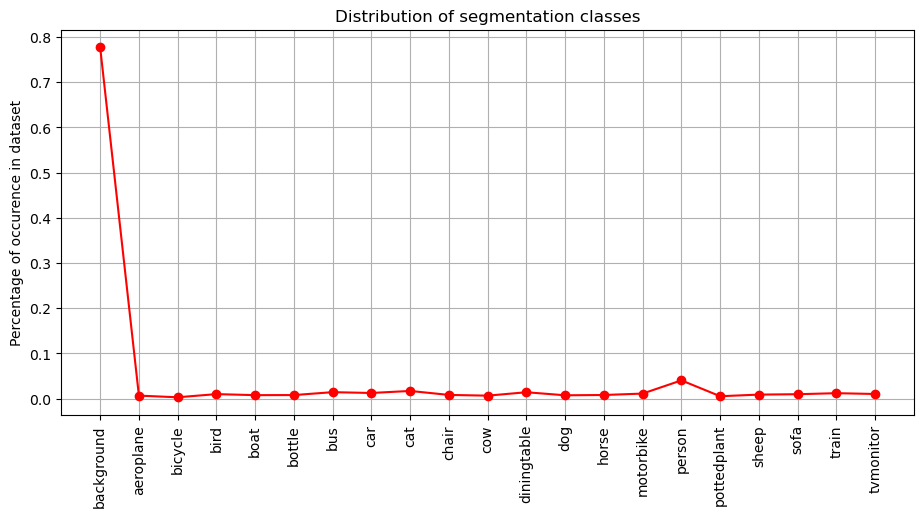

In [12]:
# Get segmentation pixels
seg_distr = counts_seg(train_df)
# Plot
plt.figure(figsize=(11,5))
xt = [i for i in range(len(seg_distr))]
plt.plot(xt, seg_distr, "-o", color="red")
all_labels = ["background"] + labels.tolist()
plt.xticks(xt, labels=all_labels, rotation=90)
plt.ylabel("Percentage of occurence in dataset")
plt.title("Distribution of segmentation classes")
plt.grid()
plt.show()

## 1.3 Utilities
Below, we define a few auxiliary functions. First, we define functions to simplify generating the Kaggle submission:

In [13]:
def _rle_encode(img):
    """
    Kaggle requires RLE encoded predictions for computation of the Dice score (https://www.kaggle.com/lifa08/run-length-encode-and-decode)

    Parameters
    ----------
    img: np.ndarray - binary img array
    
    Returns
    -------
    rle: String - running length encoded version of img
    """
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    rle = ' '.join(str(x) for x in runs)
    return rle

def generate_submission(df):
    """
    Make sure to call this function once after you completed Sect. 2 and Sect. 3! It transforms and writes your test dataframe into a submission.csv file.
    
    Parameters
    ----------
    df: pd.DataFrame - filled dataframe that needs to be converted
    
    Returns
    -------
    submission_df: pd.DataFrame - df in submission format.
    """
    df_dict = {"Id": [], "Predicted": []}
    for idx, _ in df.iterrows():
        df_dict["Id"].append(f"{idx}_classification")
        df_dict["Predicted"].append(_rle_encode(np.array(df.loc[idx, labels])))
        df_dict["Id"].append(f"{idx}_segmentation")
        df_dict["Predicted"].append(_rle_encode(np.array([df.loc[idx, "seg"] == j + 1 for j in range(len(labels))])))
    
    submission_df = pd.DataFrame(data=df_dict, dtype=str).set_index("Id")
    submission_df.to_csv("submission.csv")
    return submission_df

We also define an auxiliary function to reshape images using OpenCV:

In [14]:
def reshape_images(images, size):
    """
    Simple auxiliary function to reshape a given sequence of images to the square shape (size, size).
    Parameters
    ----------
    images: list, np.array - Array of images to be resized.
    size: int - Size along one dimension of the final images. Shape will be (size, size).
    
    Returns
    -------
    new_images_array: np.array -  Resized images inside a numpy array
    
    """
    new_images = []
    # Resize each image in the given sequence
    for img in images:
        resized = cv2.resize(img, (size, size), interpolation=cv2.INTER_AREA)
        new_images.append(resized)
    # Convert from list to array
    new_images_array = np.array(new_images)
    return new_images_array

In [15]:
def show_training(history, loss_key = "loss", acc_key = "adapted_accuracy"):
    """
    Plots the training of a Keras model, based on the history provided by the fit methods.
    """
    train_loss  = history[loss_key]
    val_loss    = history["val_" + loss_key]
    train_acc   = history[acc_key]
    val_acc     = history["val_" + acc_key]
    epochs_list = np.linspace(1, len(train_loss), len(train_loss))

    # Make a plot
    plt.subplots(nrows=1, ncols=1, figsize=(12, 3))

    plt.subplot(121)
    plt.plot(epochs_list, train_loss, '-o', color="red", label="Train")
    plt.plot(epochs_list, val_loss, '-o', color="blue", label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid()
    plt.yscale('log')
    plt.legend()

    plt.subplot(122)
    plt.plot(epochs_list, train_acc, '-o', color="red", label="Train")
    plt.plot(epochs_list, val_acc, '-o', color="blue", label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.grid()

    plt.show()

Utility function which plots an image from the training set (by specifying its index) as well as the output of the model to check its behaviour at prediction time.

In [16]:
def test_classification(model, X_train, img_index, threshold=0.5, verbose=True):
    """
    Tests a classification model by making predictions on a specific image.

    Args:
        model: The trained classification model.
        X_train (np.array): Image dataset to use (we have two datasets due to two different image sizes)
        img_index (int): The index of the image to be tested.
        threshold (float, optional): The threshold for class probability. Default is 0.5.

    """
    # Get image & correct label(s)
    img = X_train[img_index]  # Fetch the image from the training set
    input_img = np.expand_dims(img, axis=0)  # Add an extra dimension for batch processing
    true_label = labels[y_train[img_index] == 1].tolist()  # Get the true label(s) from the training labels

    # Make prediction with threshold
    pred = model(input_img)[0]  # Get the predicted class probabilities for the input image
    pred_indices = np.argwhere(pred > threshold)  # Find the indices where the probabilities exceed the threshold

    # Convert to strings
    pred_label = np.array(labels.tolist())[pred_indices].flatten()  # Convert the predicted indices to their corresponding labels

    # Print results
    if verbose:
        print(f"Correct   label(s): {true_label}")
        print(f"Predicted label(s): {pred_label}")

    # Plot image and prediction distribution
    plt.subplots(1, 2, figsize=(15, 5))
    plt.subplot(121)
    plt.imshow(img)
    title = ""
    plt.title(true_label)
    plt.xticks([])
    plt.yticks([])

    # Plot distribution
    plt.subplot(122)
    xt = [i for i in range(len(pred))]
    plt.plot(xt, pred, "-o", color="red")
    plt.xticks(xt, labels=labels, rotation=90)
    plt.ylabel("Probability")
    plt.grid()
    plt.axhline(threshold, ls="--", color="black")

    plt.show()

In [17]:
def test_segmentation(model, index):
    """
    Predicts image classes and displays visualizations.

    This function takes a model and an index as input, performs prediction
    on the image using a pre-trained model, and displays visualizations of
    the image and the predicted classes.

    Returns:
        None
    """

    # Get the image and its segmentation
    img = X_val[i]
    seg = y_val[i]
    seg = np.argmax(seg, axis=2)
    
    # Reshape the image to match the model's input shape
    x = tf.reshape(img, (-1, 224, 224, 3))

    # Perform prediction on the image using the pre-trained model
    pred = model.predict(x)

    # Extract the predicted class labels from the predictions
    imclass = np.argmax(pred, axis=3)[0, :, :]

    # Print the unique class labels in the predicted classes
    print(np.unique(imclass))

    # Create a figure to display the visualizations
    fig, axs = plt.subplots(1, 3, figsize=(15, 7))

    # Plot the original image
    plt.subplot(1, 3, 1)
    plt.imshow(np.asarray(img))

    # Plot the predicted classes
    plt.subplot(1, 3, 2)
    plt.imshow(imclass)
    cbar = fig.colorbar(im, ax=axs[1], shrink=0.75, ticks=np.linspace(1, 20, 20))
    cbar.ax.set_yticklabels(labels)

    # Plot the original image again
    plt.subplot(1, 3, 3)
    plt.imshow(np.asarray(seg), vmin=0, vmax=20)
    cbar = fig.colorbar(im, ax=axs[2], shrink=0.75, ticks=np.linspace(1, 20, 20))
    cbar.ax.set_yticklabels(labels)

    # Mask the predicted classes where the label is 0
    masked_imclass = np.ma.masked_where(imclass == 0, imclass)
    
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])

Utility function to compute the predictions of our classification function:

In [18]:
def get_predicted_classes(predictions, threshold=0.5, use_argmax=True):
    """
    Utility function that gets the predictions that are above the decided threshold.
    
    Parameters
    ----------
    predictions: List of vectors with predictions made by a model.
    threshold: Number between [0,1] that will set the threshold for deciding if intermediate numbers get transformed to 0 or 1.
    use_argmax: Boolean value that sets if we want to force an argmax so that there is at least 1 one prediction made in each vector.
    
    Returns
    -------
    yhat: List of predictions above decided threshold.
    
    """
    # Apply threshold    
    yhat = np.where(predictions > threshold, 1, 0)
    
    if use_argmax:
        thresholded = yhat.copy()
        for i, pred in enumerate(yhat):
            if not(1 in pred):
                index = np.argmax(predictions[i])
                yhat[i, index] = 1
            
    return yhat

## 1.4 Metrics

In addition to the utility functions, we also include a couple of classes/functions that work towards improving the evaluation of the performance of the models. Firstly, a subclass of keras.Metric is implemented:

In [19]:
class AdaptedAccuracy(tf.keras.metrics.Metric):
    """
    Metric that gives the ratio between the number of perfect predictions (when the predicted vector completely matches real vector) and the number of total predictions.
    
    """
    def __init__(self, thres=0.5, name='adapted_accuracy', **kwargs):
        """
        Initializes the state variables.

        Parameters
        ----------
        thres: Number between [0,1] that will set the threshold for deciding which intermediate numbers get transformed to 0 or 1.
        name: Name of the metric.
        
        """ 
        super(AdaptedAccuracy, self).__init__(name=name, **kwargs)
        self.thres = thres
        self.count = self.add_weight(name='count', initializer='zeros')
        self.total = self.add_weight(name='total', initializer='zeros')
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        """
        Updates the state given a new batch of predictions and its correspondent set of real values.

        Parameters
        ----------
        y_true: List of vectors with true labels.
        y_pred: List of predicted vectors.
        
        """ 
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)

        count = 0
        for i in range(len(y_true)):
            if (y_true[i].numpy() > self.thres).tolist() == (y_pred[i].numpy() > self.thres).tolist():
                count += 1
        length = len(y_pred)

        self.count.assign_add(count)
        self.total.assign_add(length)

    def result(self):
        """
        Returns the scalar metric result.

        Returns
        -------
        self.count / self.total: Final adapted accuracy score.
        
        """
        return self.count / self.total

    def reset_state(self):
        """
        Resets all the metric state variables to their initial values.

        """
        self.count.assign(0.0)
        self.total.assign(0.0)

Now, an implementation of the Dice score is coded, so that it can be used as a more accurate way of anticipating the performance of the models for the competition

In [20]:
def dice_classification(y, yhat, threshold=0.5, use_argmax=True):
    """
    Metric function that calculates the Dice score based on the sets of just predicted labels.
    
    Parameters
    ----------
    y: List of real labels.
    yhat: List of predictions above decided threshold.
    threshold: Number between [0,1] that will set the threshold for deciding if intermediate numbers get transformed to 0 or 1.
    use_argmax: Boolean value that sets if we want to force an argmax so that there is at least 1 one prediction made in each vector.
    
    Returns
    -------
    2. * np.sum(intersection) / (np.sum(y) + np.sum(yhat)): Dice score.
    
    """
    yhat = get_predicted_classes(yhat, threshold=threshold, use_argmax=use_argmax)
    y_ones = np.argwhere(y == 1).flatten()
    yhat_ones = np.argwhere(yhat == 1).flatten()
    
    y = y.astype(bool)
    yhat = yhat.astype(bool)
    intersection = np.logical_and(y, yhat)
    return 2. * np.sum(intersection) / (np.sum(y) + np.sum(yhat))

# 2. Image classification

### Preprocessing:

First, we reshape the images into the desired shape that the architectures use. For most cases, this size will be ( 224 , 224 ) , while for the fourth model the required size is ( 299 , 299 ) . Therefore, from each X variable will be divided in 2 after reshaping. In the end, we have 749 train images of size ( 224 , 224 ) , the same 749 images but with size ( 299 , 299 ) , and their corresponding label. These labels are a vector of size 20 that contain binary values, indicating whether the class is present in the label or not.

In [35]:
X_train = reshape_images(train_df["img"], 224)
y_train = np.asarray(train_df[train_df.columns[:20]])

# Bigger image size, for Xception
X_train_big = reshape_images(train_df["img"], 299)

Shape of X_train is (749, 224, 224, 3)
Shape of X_test  is (750, 224, 224, 3)
Shape of y_train is (749, 20)
Shape of X_train_big is (749, 299, 299, 3)
Shape of X_test _big is (750, 299, 299, 3)


## 2.0 Introduction and overview


As already mentioned, this first section will deal with the classification task of the Pascal VOC dataset. The goal is to implement a convolutional neural network to recognise all the 20 classes of the dataset, as shown for instance in the example image above. Before we delve into the code, we provide an overview and explanation of the different set-ups we have considered for this work, to keep the discussion compact and organized. We considered different architectures, and trained each architecture on three different mechanisms. 

### 2.0.1 Architectures

All architectures consist of similar building blocks called **layers**. CNNs have different layers. For instance, a **convolutional layer** performs a convolution operation on the input data, but with the learnable parameters in the kernel which hence learn the most important features of images. Possible hyperparameters are the number of filters that are present in such a layer, the kernel size, the padding used during convolution and the stride. Since convolutional layers share the weights and biases, they provide translational invariance, which is a crucial property of image data. Next, **pooling layers** allow us to decrease the size of images through downsampling. The original image is subdivided into smaller parts, and for each part, we retain only a single value. For instance, we can consider $2\times 2$ subparts of the images and keep the average or the maximum of their pixel values. Between such layers, one can encounter non-linear activation layers, commonly using the ReLU activation function, defined as $\text{ReLU}(x) = \max(0, x)$. It introduces non-linearity to the architecture, allowing it to build more complicated features out of the data. After stacking several convolutional and pooling layers, CNNs often end with a fully connected (dense) layers. The goal of a CNN is to be able to learn abstract, non-linear features from images and downsample these to a size that can easily be fed into a regular multi-layer perceptron architecture, which then learns to process these features into the desired output, such as the 20 classes of the Pascal VOC dataset.

We now discuss the different architectures that we investigated for our application.

The first architecture we consider is **MobileNetV2**, developed at Google [1]. The architecture is simple and makes use of bottleneck residual blocks besides the conventional convolutional and pooling layers. These consist of a sequence of three layers. The first is a $1 \times 1$ 2D convolutional layer with a ReLU6 activation function ($\text{ReLU6}(x) = \min\left( \max\left( 0, x \right), 6 \right)$). The second is a $3 \times 3$ depthwise convolutional layer, again with ReLU6 activation function. A *depthwise separable convolution* factorizes the standard convolutional operator into two layers. The first layer is a depthwise convolution which uses a single convolutional filter per input channel. The second layer performs a pointwise convolution, with kernel size $1 \times 1$, to build new features. The advantage of these operators is that their computational cost is 8 to 9 times smaller than standard convolutions, at only a small reduction in the accuracy. The final part of the bottleneck residual block uses a linear $1\times 1$ convolutional layer. Overall, MobileNetV2 has less parameters than MobileNetV1 (discussed below).

The precise architecture is shown below. First, a regular convolution is applied. Then, several linear bottleneck layers, discussed in detail in the paper, are applied. Finally, after the image has been downsampled to a $7\times 7$ image with 1280 kernels, an averaging pool is used to get a vector of $1280$ features which can then be processed into a classifier. Below, we flatten the output layer (to go from shape $1\times 1 \times 1280$ to shape $1280$) and process these features into a classifier. 
<figure style="text-align: center;">
    <img src=https://miro.medium.com/v2/resize:fit:1016/1*5iA55983nBMlQn9f6ICxKg.png>
    <figcaption>The MobileNetV2 architecture.</figcaption>
</figure>

The second architecture we investigate is **VGG16** [2]. The novel insight that this paper put forward was that significant improvements in the accuracy can be achieved by increasing their depth by adding more convolutional layers, which is made feasible by using very small $3 \times 3$ convolutional filters in all layers, which is the smallest receptive field that can capture the notions of left/right and down/up. The network uses standard ReLU activation functions. The drawback of the architecture is that it is over 533MB, which makes deploying VGG a tiresome task [3]. Smaller network architectures can therefore be desirable. VGG16 outperformed state-of-the-art models at its time of introduction in the ILSVRC-2012 and ILSVRC-2013 competitions. The architecture is shown below:
<figure style="text-align: center;">
    <img src="https://miro.medium.com/v2/1*NNifzsJ7tD2kAfBXt3AzEg.png" width=75%>
    <figcaption>The VGG16 architecture.</figcaption>
</figure>

The third architecture we consider is the **InceptionV3** [4]. It addressed the computational complexity of deep models such as VGG16 and came up with a way to easily scale up such models to larger sizes. The key insight that this paper used is that larger convolutional filters, such as $5\times 5$ or $7\times 7$, while much more expensive to evaluate, can capture dependencies between signals further away. In order to still use such larger kernels but without an increased computation time, the idea was to replace these convolutions with a multi-layer network with less parameters but the same input and output sizes. For instance, a $5 \times 5$ convolutional layer can be replaced by a two layers of $3 \times 3$ convolutions. This reduces the number of parameters by sharing the weights between the adjacent tiles. This leads to a $28\%$ relative gain in computation time. Besides, the model was trained using label-smoothing regularization. That is, instead of having a fixed "ground truth" label, the label is replaced by a distribution which represents a mixture between the original ground truth distribution and a fixed distribution. This prevents the largest logit of the network to become much larger than all other logits, which may result in better generalization.  

<figure style="text-align: center;">
    <img src="https://pytorch.org/assets/images/inception_v3.png">
    <figcaption>The InceptionV3 architecture.</figcaption>
</figure>

The fourth architecture explored is Xception [5]. It is inspired by the previous architecture Inception and it has the same number of parameters as InceptionV3. The slight outperformance on specific datasets comes from the replacement of the Inception modules by depthwise separable convolutions, understood as an Inception module with a maximally large number of towers. Another difference from the previous one is that the Xception architecture is described as a linear stack of depthwise separable convolution layers with residual connections, so its implementation on high-level libraries becomes easier than InceptionV3's.

<figure style="text-align: center;">
    <img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*t6qfo9ucYza_lbLfg5-p_w.png">
    <figcaption>The InceptionV3 architecture.</figcaption>
</figure>


The final architecture that we consider is **MobileNet**, the predecessor of the first architecture that we discussed [5]. This original architecture also made use of depthwise separable convolution, explained above. Further details are found in the paper.
<figure style="text-align: center;">
    <img src="https://www.researchgate.net/publication/331675538/figure/fig2/AS:735605247967235@1552393366382/layers-of-MobileNet-architecture-4.ppm" width=30%>
    <figcaption>MobileNetV1 architecture.</figcaption>
</figure>

### 2.0.2 Training mechanisms

Furthermore, each architecture was trained with three different **training mechanisms**.

First, we consider the case of **transfer learning**. These classes implement pre-trained models for image classification by loading pre-trained weights from the ImageNet dataset. It allows us to leverage their performance and apply it to our specific classification task on images from the Pascal VOC dataset. After loading the architectures, we modify them by replacing the fully connected layers at the end of the network with a new flattened layer of the final output, and we add a dense (*i.e.*, fully connected) layer with a sigmoid activation function. This final layer has 20 output nodes, such that it is compatible with the Pascal VOC dataset which has 20 classes.

Second, we consider **transfer learning with fine-tuning**. Here, we allow to fine-tune the architecture on top of the transfer learning. These classes also use transfer learning as before, and hence much of the code will be similar to the previous class. However, now we include an additional step called **fine-tuning**. After the modified model is trained with the initial hyperparameters, the layers of the base models are unfrozen, allowing them to be trained along with our custom layers. This fine-tuning step aims to further improve the base model's performance by allowing the lower layers to learn more specific features from our new dataset. This allows us to get more flexibility in the model and can yield a more capable network.

Third, we consider training the architectures **from scratch**. This means that we do not import any weights from pre-trained models, but instead train the entire model on our own dataset.

### 2.0.3 Training set-up and hyperparameters

The training of all classification models generally use more or less the same **set-up and hyperparameters**. We have chosen for the **Adam optimizer** and a **binary cross-entropy loss**. In Adam, derived from “adaptive moments” one computes an unbiased estimate for the first and second moments of the gradient. Adam is generally regarded as fairly robust to the choice of hyperparameters. Details can be found in Section 8.5.3 of the book [*Deep Learning*](https://www.deeplearningbook.org/) by Goodfellow *et al.*. Since we are dealing with a multi-class, multi-label problem here, we have chosen for the binary cross entropy loss function since we encode the labels present in the image into a vector of size $20$ where the $i$-th entry can be 0 (not present) or 1 (present). TensorFlow's implementation of this loss function automatically reduces this loss function into a single number for the backpropagation. 

The models are set to be trained for 30 epochs by default on the Pascal VOC dataset. However, there is an early stopping criterion used based on the validation loss that makes the training stop if it does not detect an improvement of at least 0.01 , to prevent overfitting. Even though a parameter of patience is set to 3 so that it gives some room for fluctuations, the results show that the required number of epochs sits around 10 at its maximum. When it comes to learning rate, arguably one of the most important hyperparameters for training, this value was set to $10^{-3}$ as this empirically gave decent results. This is however only a rule of thumb and we have to modify this at some points. When using transfer learning with fine-tuning, the learning rate gets lowered to $10^{-4}$ for the first training and $10^{-7}$ for the fine-tuning. We also process the training data in batches of size 32 whenever possible, although sometimes this number has to decrease to avoid out of memory issues. And moving to the last parameter set, the validation data will be obtained from 1/4 of the initial training data. Although, when it comes to training from scratch the parameters change. The batch size used increases to 64 whenever possible to fasten the training time since the number of epochs increases drastically to 200. This drastic measure is decided becuase the starting validation loss in these cases is enormous, and sometimes even after 100 epochs the loss score is still getting lower. The learning rate also increases from $10^{-3}$ to 0.5 for some models in line with the previous points made, and the patience parameter is established at 5. The rest of the parameters remains the same. 

Lastly, for evaluating the performance of the models, a set of different metrics is used: **number of false negatives**, **precision**, **recall**, and most importantly, the **adapted accuracy** coded above. This last metric in conjunction with the loss function is the one that will have the larger weight on the decision of which model to use for the competition. The dice score is not used here yet, it will be used instead afterwards to tune the threshold parameter.


**References:**

[1] Sandler, M., Howard, A., Zhu, M., Zhmoginov, A., & Chen, L. C. (2018). *Mobilenetv2: Inverted residuals and linear bottlenecks*. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 4510-4520).

[2] Simonyan, K., & Zisserman, A. (2014). *Very deep convolutional networks for large-scale image recognition*. arXiv preprint arXiv:1409.1556.

[3] Neurohive. (2018, November 20). VGG16 - Convolutional Network for Classification and Detection. Retrieved May 16, 2023, from https://neurohive.io/en/popular-networks/vgg16/

[4] Szegedy, C., Vanhoucke, V., Ioffe, S., Shlens, J., & Wojna, Z. (2016). *Rethinking the inception architecture for computer vision*. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 2818-2826).

[5] Chollet, F. (2017). *Xception: Deep Learning with Depthwise Separable Convolutions*. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 1251-1258).

[6] Howard, A.G., Zhu, M., Chen, B., Kalenichenko, D., Wang, W., Weyand, T., Andreetto, M. and Adam, H. (2017). *Mobilenets: Efficient convolutional neural networks for mobile vision applications*. arXiv preprint arXiv:1704.04861.

## 2.1 Results

The results of the different architectures are shown in the plot below. We can clearly see that that the best result come from the family of Inception architectures, Xception being the best one. It is also easily visible that all the architectures trained from scratch fail miserably, which was expected. These 5 architectures have a lot of layers and parameters, and they are normally trained on the ImageNet image database with $1,281,167$ training images. If we compare that number with the 749 images that we have for training, it is clear that overfitting will be a big problem because there are not enough distinct images for setting the right weights from scratch. And that is what happens exactly here: all the 5 architectures have a score lower than 0.1 

Moving on to transfer learning and tranfer learning plus fine-tuning, the plot shows how there is no case in which TL+FT gets a higher score than TL. Even with really low learning rates for fine-tuning, since this procedure starts from the point of convergence of tranfer learning, we can see that the effect overfitting has on the model decreases the final score. The downgrade is not that important as the one training from scratch introduces but it has been a bit surprising to see those results. But at the same time, since we are talking about a huge number of layers/parameters in each model, it makes sense that 749 images cannot have a big possitive impact on an already well-trained model. Now, talking about the differences between the architectures themselves, we can see how VGG16 is the worst performing one, followed by the MobileNet architectures, with a larger difference when trained with fine-tuning than when they are just trained with tranfer learning. Between those last two, the plot shows the results we were expecting: MobileNetV2 performs better than MobileNet. However, they even get beaten by Xception TL+FT, showing how this architecture looks the most promising. Therefore, taking into account all the explanation above, we will work from now on with **Xception**.

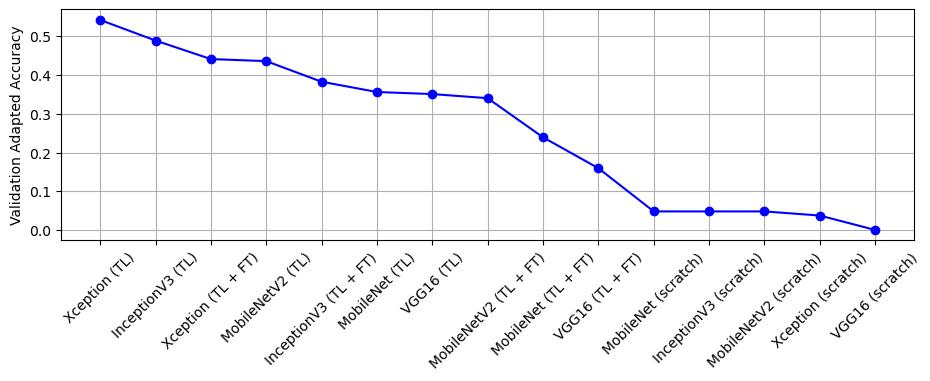

In [36]:
with open('/kaggle/input/cv-ga2-class-results/sorted_classification_names.pickle', 'rb') as handle:
    classification_names = pickle.load(handle)
    
with open('/kaggle/input/cv-ga2-class-results/sorted_classification_val_accs.pickle', 'rb') as handle:
    classification_val_accs = pickle.load(handle)
    
xticks = [i for i in range(len(classification_names))]

plt.figure(figsize=(11,3))
plt.plot(xticks, classification_val_accs, '-o', color="blue")
plt.xticks(xticks, labels=classification_names, rotation=45)
plt.grid()
plt.ylabel("Validation Adapted Accuracy")
plt.show()

## 2.2 Final model: Xception with transfer learning

The final model is shown below. After the layers of Xception, we add a custom layer that finally has 20 output nodes and which uses a sigmoid activation function, such that the output falls between 0 and 1 such that it can be interpreted as a probability. Actual predictions of the model are then obtained by taking 0.5 as a threshold: if the output of a certain node is above this threshold, then the model predicts that this class is present in the image. In principle, one can essentially view this threshold value as yet another hyperparameter, which can then be tuned on a separate validation set. However, this goes beyond the scope of this project, and we are also quite satisfied with the current performance of the model. Therefore, we will just consider varying the threshold for this final, trained model in the next section.

In [37]:
class ClassificationModel:

    def __init__(self):
        """
        Initializes a ClassificationModel object.
        """
        # Load pre-trained Xception model and freeze its layers to avoid re-training
        new_model = tf.keras.applications.Xception(include_top=False, input_shape=(299,299,3), weights="imagenet")
        for l in new_model.layers:
            l.trainable = False
        
        # Add custom layers on top of the base model
        new_l = tf.keras.layers.Flatten()(new_model.output)
        new_l = tf.keras.layers.Dense(20, activation="sigmoid")(new_l)
        self.model = tf.keras.Model(inputs=new_model.input, outputs=new_l)

    def fit(self, X, y):
        """
        Trains the model with the images and labels provided.
        
        Args:
        
            X (numpy.ndarray): Input image data with shape (num_samples, height, width, channels).
            y (numpy.ndarray): Target labels with shape (num_samples, num_classes).

        """
        # Preprocess the input data
        X_train = tf.keras.applications.xception.preprocess_input(X)
        
        # Compile the model
        self.model.compile(run_eagerly=True, optimizer=tf.keras.optimizers.Adam(1e-3), loss='binary_crossentropy',
                           metrics=[AdaptedAccuracy()])
        
        # Set up callbacks for training
        callbacks = [
            tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3),
            tf.keras.callbacks.ModelCheckpoint(filepath="/kaggle/working/classification_model.h5", monitor="val_loss", save_best_only=True)
        ]
        
        # Train the model with the pre-training settings
        self.history = self.model.fit(X_train, y, epochs=30,
                       batch_size=16, validation_split=0.25, callbacks=callbacks)

    def predict(self, X):
        """
        Predicts the class probabilities for input images.

        Args:
            X (numpy.ndarray): Input image data with shape (num_samples, height, width, channels).

        Returns:
            numpy.ndarray: Predicted class probabilities with shape (num_samples, num_classes).

        """
        return self.model.predict(tf.keras.applications.xception.preprocess_input(X), verbose=0)
    
    def __call__(self, X):
        """
        Makes predictions using the model.

        Args:
            X (numpy.ndarray): Input image data with shape (num_samples, height, width, channels).

        Returns:
            numpy.ndarray: Predicted class probabilities with shape (num_samples, num_classes).

        """
        return self.predict(X)

### 2.2.1 Training/loading the final classification model

First, we train the model (or load in the training from the memory) and discuss the learning curves we obtained.

In [38]:
if TRAIN_MODELS:
    classification_model = ClassificationModel()
    classification_model.fit(X_train_big, y_train)

In [39]:
%%capture
if not TRAIN_MODELS:
    with open('/kaggle/input/cv-ga2-class-results/classification_model.pickle', 'rb') as handle:
        classification_model = pickle.load(handle);

In [40]:
## To save the trained model:
# with open('/kaggle/working/classification_model.pickle', 'wb') as handle:
#     pickle.dump(classification_model, handle, protocol=pickle.HIGHEST_PROTOCOL)

Here, we show the final training epochs for our chosen **Xception** model, which was trained with just transfer learning. We observe that it is really easy to overfit on the training data, since the highest validation accuracy and lowest validation loss is obtained on the second epoch. These numbers improve drastically on the training data while staying similar from the first iteration on the validation data. The good thing is that this does not imply that the performance has to be bad. It is quite the opposite, the performance is already good since the first epoch.

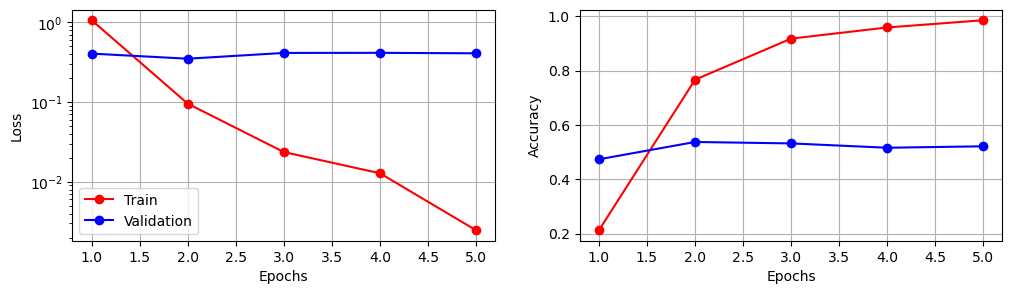

In [41]:
show_training(classification_model.history.history, acc_key="adapted_accuracy")

### 2.2.2 Checking performance of the model

Even though we can use metrics and monitor the loss during training, it is often informative to check the predictions of the model and assess it qualitatively. Below, we show an example where the model is able to correctly predict all the classes present in an image:

Correct   label(s): ['bottle', 'person', 'sofa']
Predicted label(s): ['bottle' 'person' 'sofa']


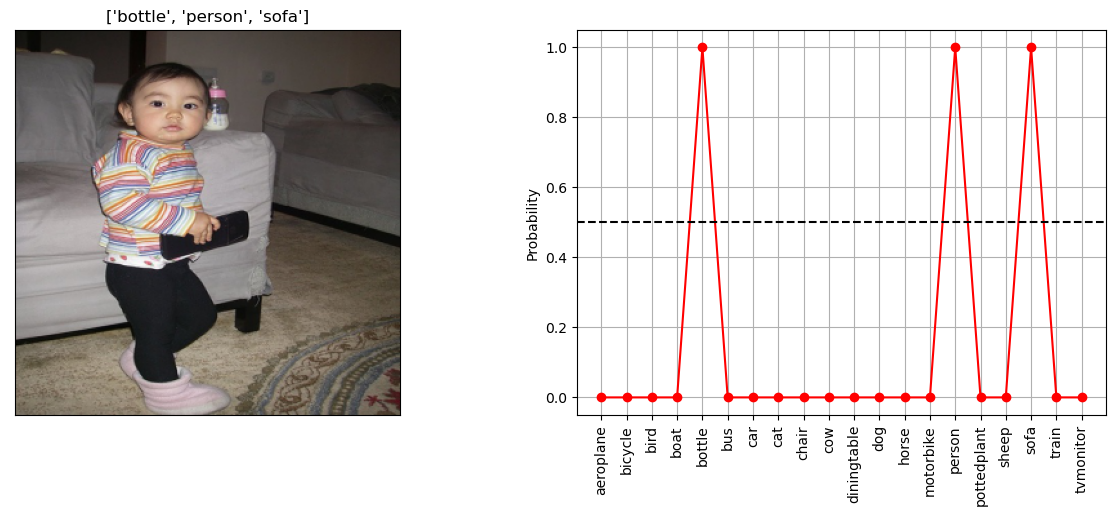

In [42]:
test_classification(classification_model, X_train_big, 15)

Here's an example from the validation data where the model misses one of the classes present in the image. It detects the people quite clearly (it is also the most frequent class) but it misses the diningtable while it almost detects bottle. Tuning the threshold by increasing it this time could help making sure this last class does not get detected, but there might be other cases where we would like it to be lower as well.

Correct   label(s): ['diningtable', 'person']
Predicted label(s): ['person']


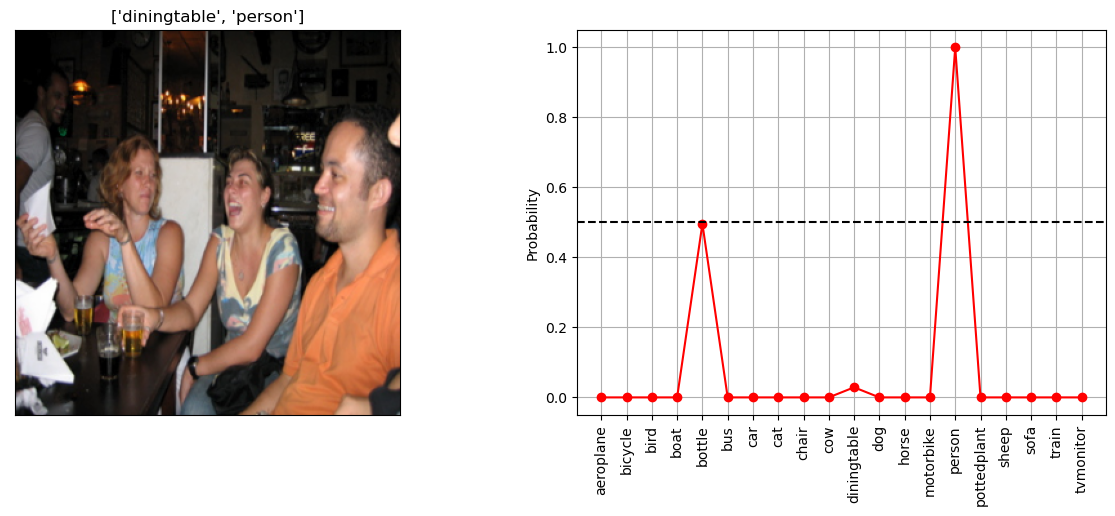

In [43]:
test_classification(classification_model, X_train_big, 700)

Another example from the validation data where we would want to tune the threshold is this one, where we easily predict one class but the probability number of the car class does not reach the default threshold:

Correct   label(s): ['bus', 'car']
Predicted label(s): ['bus']


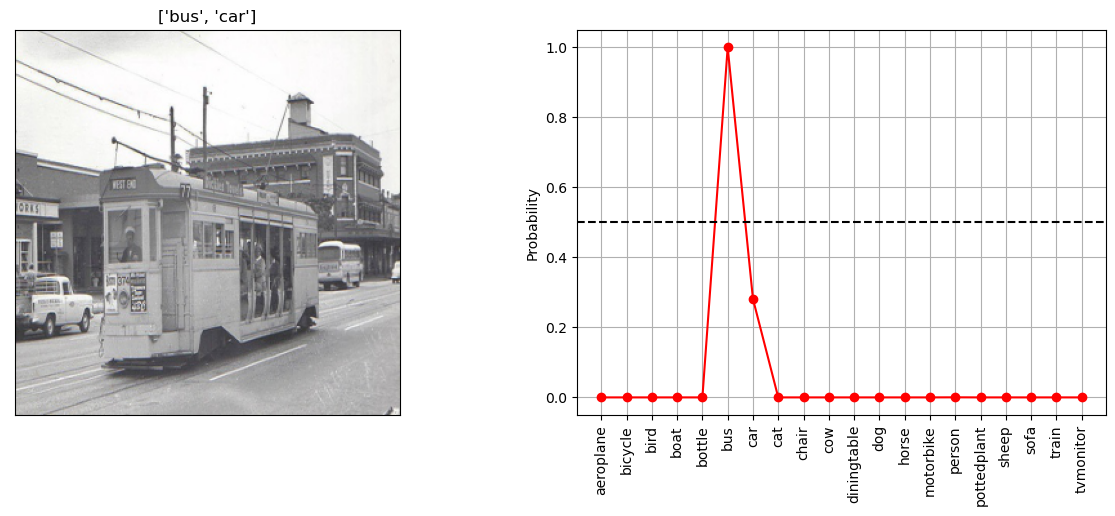

In [44]:
test_classification(classification_model, X_train_big, 241)

### 2.2.3 Threshold tuning and the argmax "hack"

As said previously, another implemented metric was the **Dice score**, which was not used during training but since it will be used for the competition, it has to be taken into consideration. We use it as a way of improving the overall predictions of the model a bit, by analyzing the Dice score we would get for each threshold value from 0 to 1. We could also add the Dice score as a custom defined metric that is added to the metrics that Keras tracks during training, but we did not have sufficient time to fully consider this implementation.

In addition to that, there is also another little trick that we have tried to see if you could improve the performance of the model. The trick is based on the observation that the Pascal VOC dataset has images which contain at least one class of the 20 classes of interest. Therefore, if the model predicts no class to be present at all, we know for a guarantee that this is a wrong prediction. Therefore, we can force the model to still make a prediction in such a scenario. That is, if we detect that an image gets no predicted classes above the threshold, we can force an argmax so that at least there is 1 prediction, knowing beforehand that every image has at least one true class. As a starting point for all this, we define an auxiliary function that turns the predictions of the output layer into predictions suitable for the Kaggle competition and the following functions:

In [45]:
def get_predicted_classes(predictions, threshold=0.5, use_argmax=True):
    """
    Predictions has shape (n_samples, n_classes). Predictions: these are the NON thresholded values.
    
    """
    # Apply threshold    
    yhat = np.where(predictions > threshold, 1, 0)
    
    if use_argmax:
        thresholded = yhat.copy()
        for i, pred in enumerate(yhat):
            if not(1 in pred):
                index = np.argmax(predictions[i])
                yhat[i, index] = 1
            
    return yhat

Now, we will use this function with its two different argmax settings to see its behaviour below. Having tried it empirically, the performance of the model remains similar with no significant improvements. Therefore, it will not be used for the submission, although we wanted to explain the possibilities that it opens.

Now, we analyze the Dice score for a **varying threshold**, so we can select the value that gives the best result for the predictions. The plot we see below might seem a bit weird at first, but the high Dice score for almost the entire threshold value space is explainable. This Xception model has, while getting just around 0.54 as Adapted Accuracy, a Dice score of around 0.94 with the default threshold of 0.5 . This is already a great result, and the tuning we are conducting just influences a couple of cases where classes that are not present in the image get a probability value just below 0.5. This happens because the sigmoid activation function is not mutually exclusive that lets different classses to get high score. So, the classes the model thinks they are present in the image will get a really high score, close to 1, while the other will get scores close to 0.01. That is why, in general terms, there is almost no difference on where you locate the threshold value. As long as it is not in the corners of the plot (near 0 and 1), the results will remain similar. Here, as we can see, we get a propose threshold value of 0.6364 for the whole training dataset, which would get a Dice score of 0.943 . However, since this test has been conducted on the training data already seen by the model and there are no big differences (unlike what it would happend with other worse-performing models we have talked about before), we will not set a different threshold for the test predictions. 

In the end, this analysis gives us insight into the performance of the model. We can conclude that the model is quite robust and the final activation layer outputs values either close to 0 or close to 1, demonstrating the robustness of our classification model.

In [ ]:
yhat = classification_model(X_train_big)
yhat1 = get_predicted_classes(yhat, threshold=0.5, use_argmax=False)
summed = np.sum(yhat1, axis=1)
print(f"With use_argmax=False -> There are {np.sum(np.where(summed == 0, 1, 0))} empty predictions among {len(yhat1)} predictions.")

yhat2 = get_predicted_classes(yhat, threshold=0.5, use_argmax=True)
summed = np.sum(yhat2, axis=1)
print(f"With use_argmax=True -> There are {np.sum(np.where(summed == 0, 1, 0))} empty predictions among {len(yhat2)} predictions.")

Baseline for default threshold 0.5: 0.9418
Best threshold value   (no argmax): 0.6318 (dice: 0.9430)
Best threshold value      (argmax): 0.9500 (dice: 0.9463)


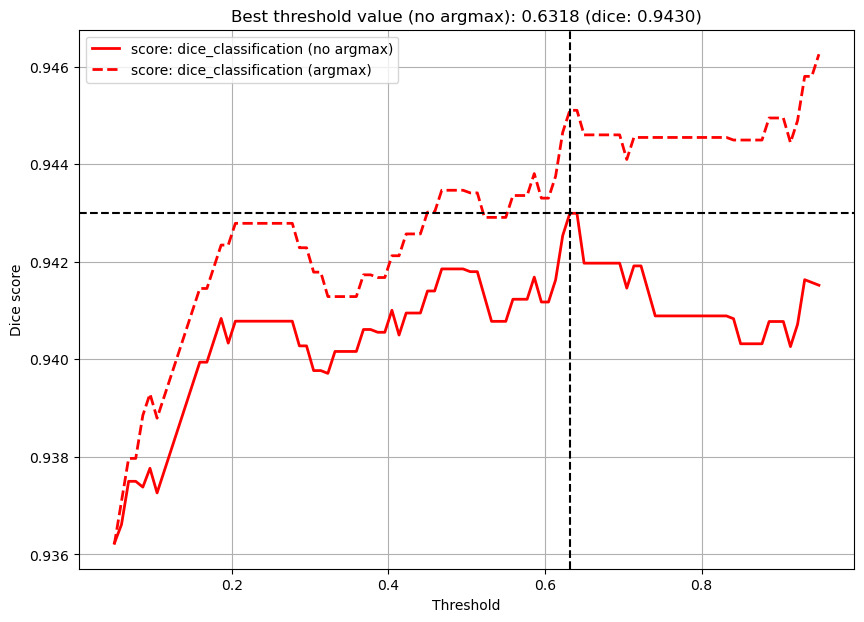

In [55]:
threshold_list = np.linspace(0.05, 0.95, 100)
values_list_1 = [dice_classification(y_train, yhat, threshold = threshold, use_argmax=False) for threshold in threshold_list]
values_list_2 = [dice_classification(y_train, yhat, threshold = threshold, use_argmax=True) for threshold in threshold_list]
baseline = dice_classification(y_train, yhat, threshold = 0.5, use_argmax=False)

plt.figure(figsize=(10, 7))
plt.plot(threshold_list, values_list_1, "-", lw=2, color="red", label = "score: dice_classification (no argmax)")
plt.plot(threshold_list, values_list_2, "--", lw=2, color="red", label = "score: dice_classification (argmax)")

plt.grid()
plt.xlabel("Threshold")
plt.ylabel("Dice score")
plt.legend()
# Check where the max is located
best_index = np.argmax(values_list_1)
best_dice = np.max(values_list_1)
best_threshold = threshold_list[best_index]
# Same for second set
best_index_argmax = np.argmax(values_list_2)
best_dice_argmax = np.max(values_list_2)
best_threshold_argmax = threshold_list[best_index_argmax]
# Plot the best one
plt.axhline(best_dice, ls="--",color="black")
plt.axvline(best_threshold, ls="--",color="black")
print(f"Baseline for default threshold 0.5: %0.4f" % (baseline))
print(f"Best threshold value   (no argmax): %0.4f (dice: %0.4f)" % (best_threshold, best_dice))
print(f"Best threshold value      (argmax): %0.4f (dice: %0.4f)" % (best_threshold_argmax, best_dice_argmax))
plt.title(f"Best threshold value (no argmax): %0.4f (dice: %0.4f)" % (best_threshold, best_dice))
plt.show()

## 2.3 Prepare classification submission

We are going to fill the first 20 columns of the test dataframe that give the predictions that our classifier makes.

In [ ]:
test_df.head(1)

First, predict the labels for all images in the dataset:

In [ ]:
def predict_test_classification(classification_model, threshold=0.5, use_argmax=True, img_size=299):
    """
    Predicts the classification of the Kaggle test set and puts them into test_df
    """
    # Get test images in correct size
    X_test  = reshape_images(test_df["img"], img_size)
    # Make prediction
    pred = classification_model(X_test)
    # Convert to label predictions
    pred = get_predicted_classes(pred, threshold=threshold, use_argmax=use_argmax)
    # Store in test array
    for i in range(len(test_df)):
        test_df.loc[i, test_df.columns[:20]] = pred[i]

In [ ]:
predict_test_classification(classification_model)

In [ ]:
test_df.head(1)

# 3. Semantic segmentation
The goal here is to implement a segmentation CNN that labels every pixel in the image as belonging to one of the 20 classes (and/or background). 

**Note:** we easily run in out-of-memory issues when training or loading several large models, so we delete variables and use garbage collect to ensure we have sufficient space.

In [57]:
del X_train
del y_train
del X_train_big
del classification_model
for i in range(10):
    gc.collect()

NameError: name 'X_train' is not defined

## 3.0 Data preprocessing and utilities

### Auxiliary functions

We first define a few auxiliary functions to preprocess the image data. We have considered data augmentation as well as cropping images. However, we did not obtain significant improvements from these steps, and we merely display the code here to illustrate a possible extended pipeline.

In [21]:
def cut_image(img, seg):
    """
    Cuts the images to a certain region of interest around all objectss.
    """
    # Encontrar los índices de las filas y columnas donde los valores son diferentes de cero
    filas, columnas = np.nonzero(seg)

    # Obtener los índices mínimo y máximo para las filas y columnas
    inicio_fila = np.min(filas)
    fin_fila = np.max(filas)
    inicio_columna = np.min(columnas)
    fin_columna = np.max(columnas)
    
    init=np.min([inicio_fila, inicio_columna])
    end=np.max([fin_fila, fin_columna])
    
    fin_fila = np.min([end, len(img)-1])
    fin_columna =np.min([end, len(img[0])-1])
    
    img_recortada = img[init:fin_fila+1, init:fin_columna+1]
    seg_recortada = seg[init:fin_fila+1, init:fin_columna+1]

    return [img_recortada, seg_recortada]

In [22]:
def augment(input_image, input_mask):
    """
    Augments an input image and its corresponding mask by randomly flipping them horizontally.

    Args:
        input_image (tf.Tensor): The input image tensor.
        input_mask (tf.Tensor): The input mask tensor.

    Returns:
        Tuple[tf.Tensor, tf.Tensor]: A tuple containing the augmented image and mask tensors.
    """
    if tf.random.uniform(()) > 0.5:
        # Randomly flip the image and mask horizontally
        input_image = tf.image.flip_left_right(input_image)
        input_mask  = tf.image.flip_left_right(input_mask)
    return input_image, input_mask

In [23]:
def normalize(input_image, input_mask):
    """
    Normalizes an input image by dividing it by 255.0 and casts it to float32.

    Args:
        input_image (tf.Tensor): The input image tensor.
        input_mask (tf.Tensor): The input mask tensor.

    Returns:
        Tuple[tf.Tensor, tf.Tensor]: A tuple containing the normalized image and the original mask tensor.
    """
    # Normalize the input image by dividing it by 255.0 and cast it to float32
    input_image = np.asarray(input_image).astype('float32')
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

### Preprocess image data

We now preprocess the data. We make use of **one-hot encoding**, which creates vectors as class labels rather than integers. For instance, if we have three classes, then the classes $\texttt{1}, \texttt{2}, \texttt{3}$ are represented as $\texttt{[1, 0, 0]}, \texttt{[0, 1, 0]}, \texttt{[0, 0, 1]}$, respectively. It is also common for training segmentation models to **normalize** the images, by dividing by the maximal pixel value, $255$. We perform a train-validation-test split as well which is used to train the model and monitor the loss during training on unseen data, respectively.

In [24]:
CROPPING = False
if CROPPING:
    # Recorrer las dos columnas utilizando zip() y una comprensión de listas
    resultados = [cut_image(x, y) for x, y in zip(train_df["img"], train_df["seg"])]

    # Asignar los resultados a r1 y r2
    train_df["img_n"] = [x[0] for x in resultados]
    train_df["seg_n"] = [x[1] for x in resultados]
    # Resize training data
    X_train = train_df["img_n"].map(lambda img:  cv2.resize(img, (224,224)))
    y_train = train_df["seg_n"].map(lambda img:  cv2.resize(img, (224,224), interpolation=cv2.INTER_NEAREST))

else :
    # Resize training data
    X_train = train_df["img"].map(lambda img:  cv2.resize(img, (224,224)))
    y_train = train_df["seg"].map(lambda img:  cv2.resize(img, (224,224), interpolation=cv2.INTER_NEAREST))

# Convert to arrays for compatibility with Keras
X_train = np.array(X_train.values.tolist())
y_train = np.array(y_train.values.tolist())

# Convert labels to categorical:
num_classes=21
y_train = to_categorical(y_train, num_classes=num_classes)
# Split into train validation sets
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.2, random_state=1)
# Normalize:
X_train, y_train = normalize(X_train, y_train)
X_val, y_val     = normalize(X_val, y_val)

In [25]:
print(f"Shape of train      images:       {np.shape(X_train)}")
print(f"Shape of train      segmentation: {np.shape(y_train)}")
print(f"Shape of validation images:       {np.shape(X_val)}")
print(f"Shape of validation segmentation: {np.shape(y_val)}")

Shape of train      images:       (599, 224, 224, 3)
Shape of train      segmentation: (599, 224, 224, 21)
Shape of validation images:       (150, 224, 224, 3)
Shape of validation segmentation: (150, 224, 224, 21)


## 3.1 Discussion and overview

We discuss the different architectures that we investigated for this task. As before, we provide a high-level discussion and overview here and immediately move on to showing the results of our final architecture. We refer readers to Appendix B for more details regarding our the architectures and the training results. In particular, Appendix B demonstrates the approaches that we considered to tackle the imbalanced that is present in the dataset for the segmentation task. 

Recall that in **image segmentation**, the goal is to perform pixel-wise classification, where the goal is to assign a label to each pixel in an image. Hence, the output is again an image (of the same shape as the original image), where the pixels denote the class label. As such, many segmentation networks have an **encoder-decoder** structure, where a first part encodes the original image into a lower-dimensional representation consisting of abstract features using the same basic layers that were discussed in the previous section for the classification part. The image is hence downsampled, and the point in the architecture where the lowest size is obtained is referred to as the bottleneck. Since the output has to be an image of the same shape, the second part of these networks decode the obtained features and, ideally, convert them into the segmented image. Therefore, when applying transfer learning, we can benefit from existing architectures for the encoding step, as these have been trained on much more data for longer periods and are hence likely well-adapted at capturing the important features from images. 


The first architecture we considered was the **U-Net** architecture [1]. Originally introduced in the context of biomedical image segmentation, U-Net is divided in four blocks in both the encoding and decoding. The architecture is very symmetric around the bottleneck in the encoding and decoding schemes, such that its diagram visually represent a U shape, as seen below. Each encoder block contracts the spatial dimension by half and double the number of channels. Therefore, the images have the highest number of channels at the bottleneck. Moreover, each decoding block is connected to the encoding block that is located on the same depth through a so-called skip connection. That is, every step of the expansive path consists of an upsampling due to an up-convolution (the inverse of a convolutional layer, essentially) which is concatenated with the corresponding cropped version of the encoder block at the same depth. The architecture makes use of ReLU activation functions. A representation of this architecture is presented on the following figure. Note that our implementation of the U-Net architecture is slightly different (for instance, we use different image shapes), although the general set-up is identical.

<figure style="text-align: center;">
    <img src=https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png>
    <figcaption>The U-Net architecture.</figcaption>
</figure>

Besides the U-Net architecture, we have also worked with a different architecture. In this architecture, the encoding scheme is based on **VGG16**, which we already discussed in the section on classification. After obtaining the low-dimensional features from VGG16, we then define custom layers on top of it that create the segmentation map. The precise architecture is shown and discussed in the appendix.


**References:**

[1] Ronneberger, O., Fischer, P., & Brox, T. (2015). *U-net: Convolutional networks for biomedical image segmentation*. In Medical Image Computing and Computer-Assisted Intervention–MICCAI 2015: 18th International Conference, Munich, Germany, October 5-9, 2015, Proceedings, Part III 18 (pp. 234-241). Springer International Publishing.

## 3.2 Results & submission

We have chosen for the second architecture as our final model. We now load a pretrained version of the model and apply it to the test dataset to obtain the predictions.

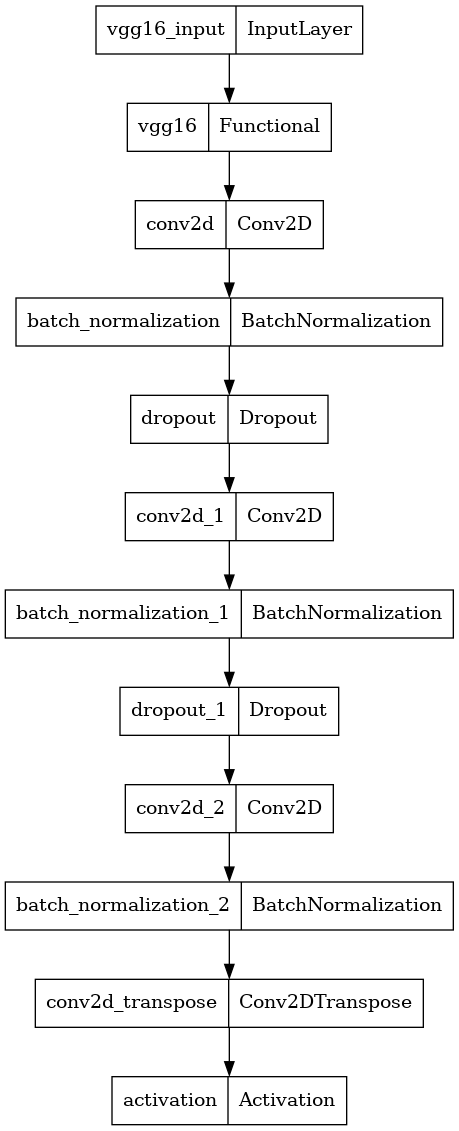

In [26]:
# Load model
segmentation_model = keras.models.load_model('/kaggle/input/models/model_vgg_2/model_vgg')
tf.keras.utils.plot_model(segmentation_model)

We define an auxiliary method that simplifies getting the segmentation predictions for the submission

In [27]:
def predict_test_segmentation(segmentation_model):
    """
    Predicts the segmentations of the Kaggle test set and puts them into test_df
    """
    for i, img in enumerate(test_norm):
        # We need the original shape for the prediction
        og_shape = np.shape(test_df.at[i, "img"])
        # Do the prediction on preprocessed data
        seg = segmentation_model(tf.reshape(img, [-1,224,224,3]))[0]
        seg = np.argmax(seg, axis=2)
        # Prepare to put it in the dataframe
        # Have to reverse the shape to get it in (width, height) format!
        seg_og_shape = cv2.resize(np.asarray(seg, dtype='uint8'), og_shape[:-1][::-1])
        test_df.at[i, "seg"] = seg_og_shape

We can check a few test cases of the model on the validation data: **TODO: discuss**

1/1 [==============================] - 6s 6s/step
[ 0 15]
1/1 [==============================] - 0s 29ms/step
[ 0  6 14]
1/1 [==============================] - 0s 22ms/step
[0 1]
1/1 [==============================] - 0s 22ms/step
[ 0  6  8 14]
1/1 [==============================] - 0s 23ms/step
[ 0 10 13 15]
1/1 [==============================] - 0s 20ms/step
[ 0  5  9 11 15 18]


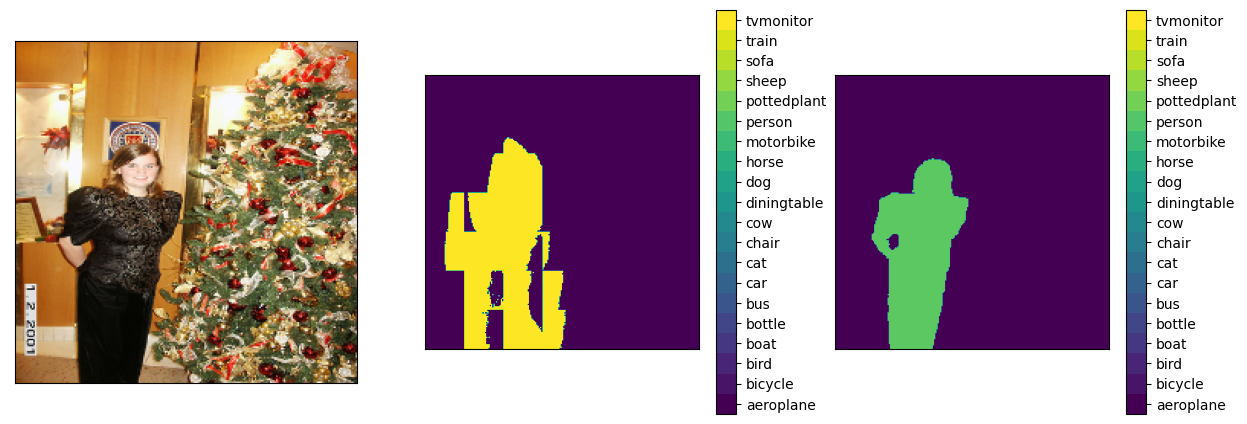

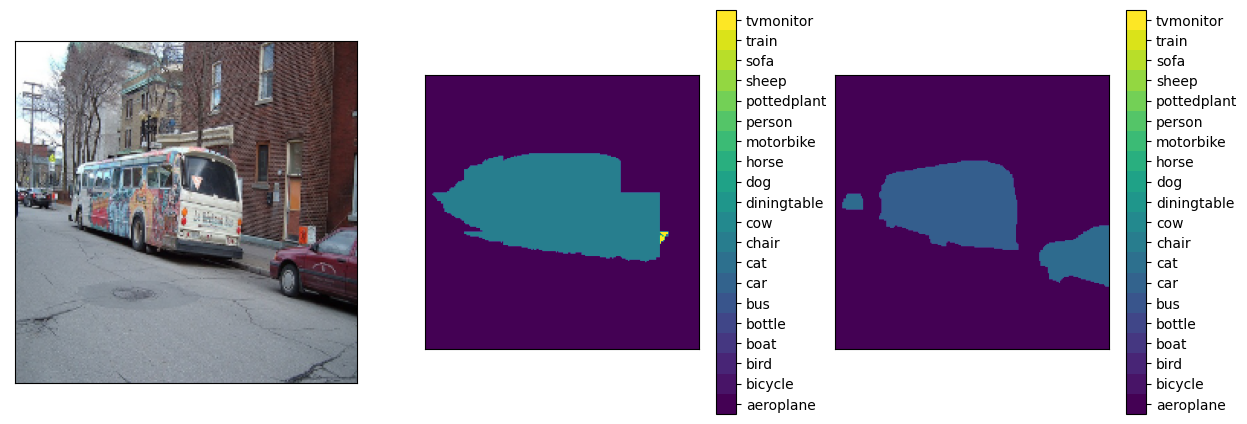

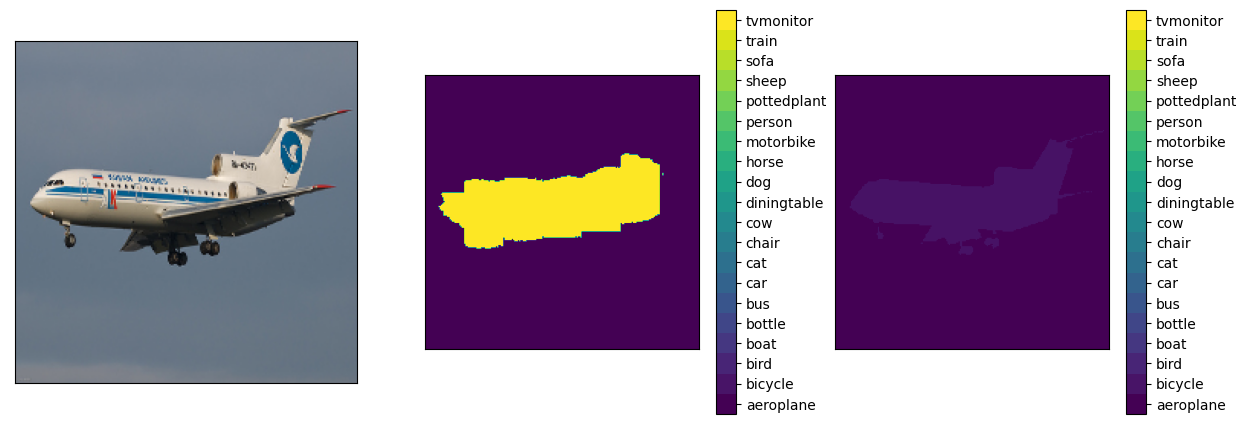

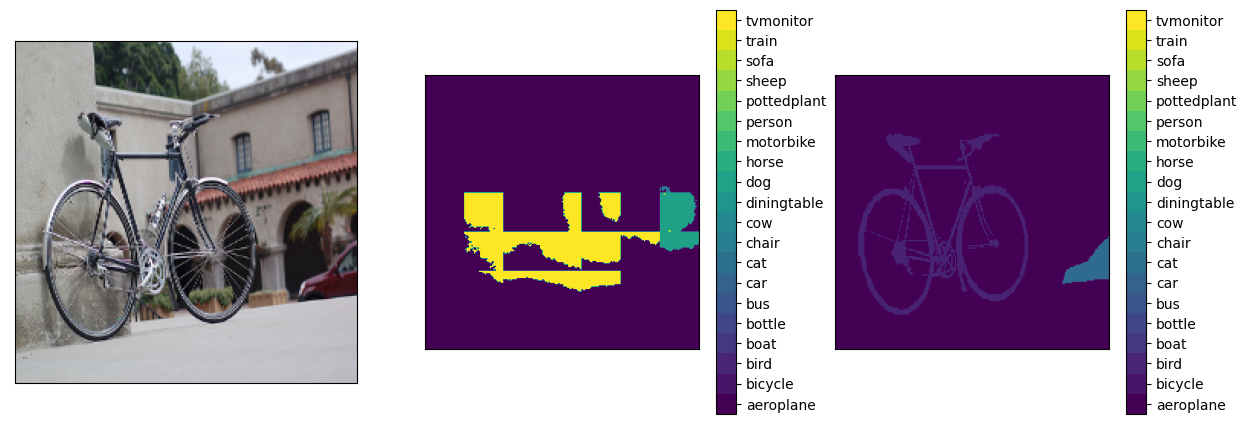

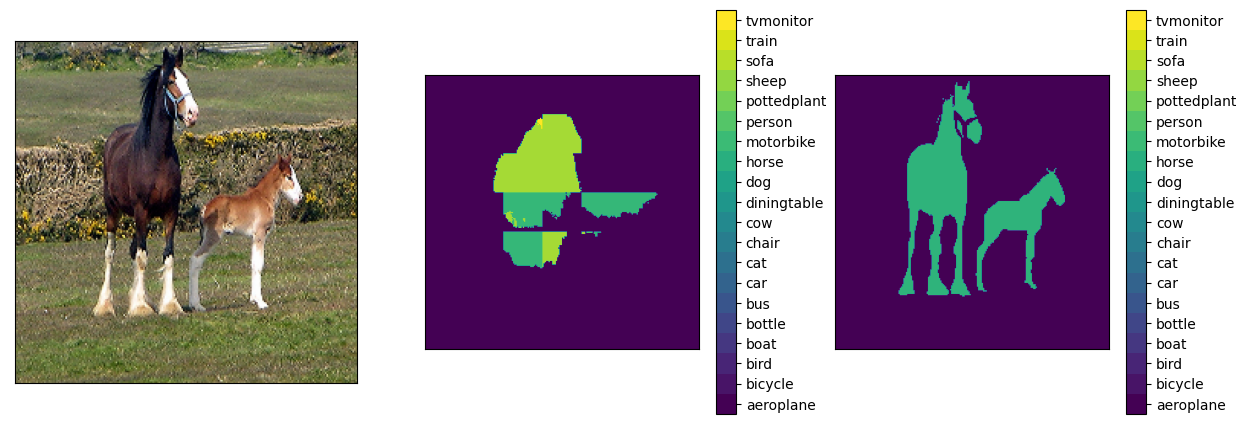

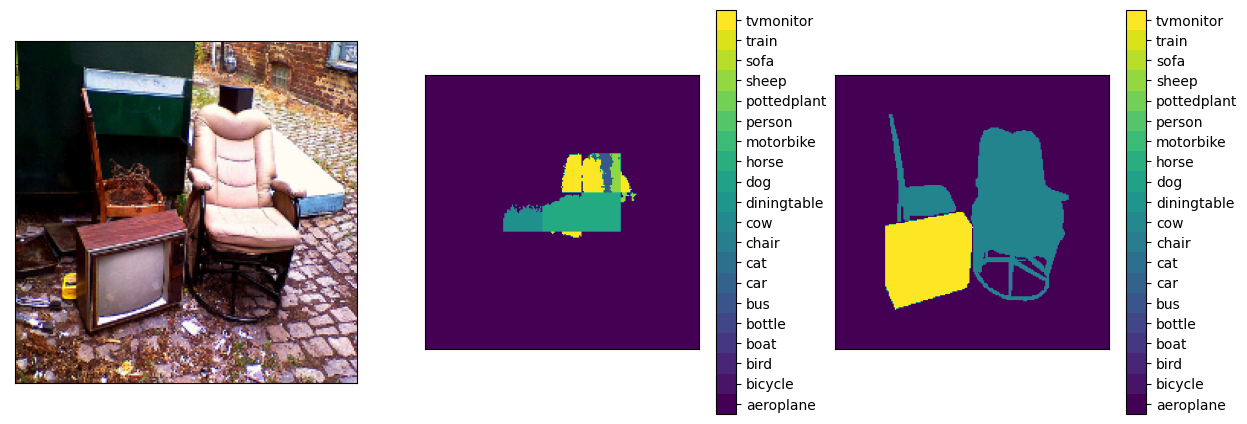

In [28]:
for i in [1, 12, 33, 14, 22, 31]:
    test_segmentation(segmentation_model, i)

We prepare the testing data for submission, and apply the same preprocessing steps to it:

In [29]:
test_df['img_n'] = test_df["img"].map(lambda img:  cv2.resize(img, (224,224)))
test_img_keras = np.array(test_df["img_n"].values.tolist())
test_norm = tf.cast(test_img_keras, tf.float32) / 255.0

We visually check that the segmentation is done correctly on the test dataset as well, to make sure that our submission is done correctly.

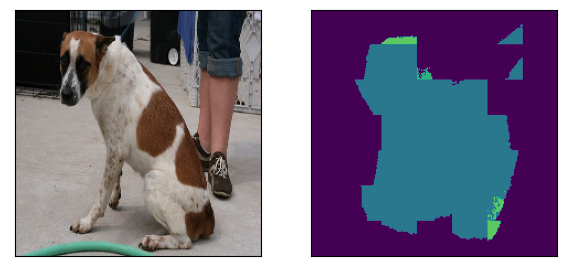

In [32]:
# Get a test image
index = 18
# Get segmentation prediction
seg = segmentation_model(tf.reshape(test_norm[index], [-1,224,224,3]))[0]
seg = np.argmax(seg, axis=2)
# Plot them
fig, axs = plt.subplots(1, 2, figsize=(7, 5))
plt.subplot(1,2,1)
plt.imshow(test_norm[index])
plt.subplot(1,2,2)
plt.imshow(seg, vmin=0, vmax=20)
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [70]:
# Finally, make the segmentaton predictions
predict_test_segmentation(segmentation_model)

# Submit to competition
Finally, we have obtained the results for the classification and prediction of our models. We can now postprocess these predictions and submit them to the Kaggle competition.

In [71]:
generate_submission(test_df)

Predicted
Id                                                                   
0_classification                                                 1 20
0_segmentation                                                       
1_classification                                                 1 20
1_segmentation      94413 1 94423 1 94917 1 97430 1 97930 1 98430 ...
2_classification                                                 1 20
...                                                               ...
747_segmentation    53166 1 53215 1 53259 2 53262 1 53264 1 53266 ...
748_classification                                               1 20
748_segmentation    79841 1 79899 30 80185 1 80196 1 80343 1 80430...
749_classification                                               1 20
749_segmentation    95619 1 95629 1 95965 1 96301 2 96638 1 96973 ...

[1500 rows x 1 columns]

In [72]:
del segmentation_model
del X_train
del train_df
gc.collect()

129280

# 4. Adversarial attack

In this part, we are going to implement an adversarial attack on one of our models. 

**NOTE:** The attack is programmed against the InceptionV3 model, since this is the one we used first instead of Xception.

## 4.1 Formulation of the attack

Our task is to perturb an image such that our classification model predicts, with high confidence, that there is a horse and a person in the image while there is actually only an airplane present.

We tried two different approaches to orchestrate the attack. The first approach we considered was the **Fast Gradient Signed Method** (FGSM). **TODO discussion**

However, the FGSM was too rudimentary to reach high confidences in the network for the target label (we are performing a targeted attack not just changing the prediction label). Therefore, we decided to switch to the **Projected Gradient Descent** (PGD) instead. 

Reasons to choose PGD over FGSM:

- FGSM is designed to be fast but not optimal (the perturbation we get may be large for the effect on the confidence it has).
- It is easy to do untargeted attacks with FGSM but it is harder for targeted attacks (we would have to search the appropiate epsilon parameter).

**References:** We followed [this tutorial](https://www.tensorflow.org/tutorials/generative/adversarial_fgsm) to implement FGSM but later changed to a custom PGD implementation following [this example](https://adversarial-ml-tutorial.org/) from Zico Kolter and Aleksander Madry. The Tensorflow code is inspired by [this link](https://github.com/cleverhans-lab/cleverhans).

In line of the context of adversarial attacks, which often happen after training and when the model is deployed in the real world ("in the wild"), we consider a random image found on the internet containing an airplane. We preprocess it and deliver it to our classification model. As expected, the model is able to accurately predict the presence of the airplane.

In [73]:
!wget https://i.insider.com/62dcfe205bf4820019b5ece7?width=700 -O airplane.webp

--2023-05-24 17:13:31--  https://i.insider.com/62dcfe205bf4820019b5ece7?width=700
Resolving i.insider.com (i.insider.com)... 151.101.2.217, 151.101.66.217, 151.101.130.217, ...
Connecting to i.insider.com (i.insider.com)|151.101.2.217|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21239 (21K) [image/jpeg]
Saving to: ‘airplane.webp’

airplane.webp       100%[===================>]  20.74K  --.-KB/s    in 0s      

2023-05-24 17:13:31 (53.9 MB/s) - ‘airplane.webp’ saved [21239/21239]



In [74]:
# Read the image file in its raw format
image_raw = tf.io.read_file('airplane.webp')

# Decode the raw image into a tensor
orig_image = tf.image.decode_image(image_raw)

def preprocess(image):
    """
    Preprocesses the image tensor for classification.

    Args:
        image (tf.Tensor): Input image tensor.

    Returns:
        tf.Tensor: Preprocessed image tensor.
    """
    # Resize the image to our chosen size
    image = tf.image.resize(image, (224, 224))

    # Preprocess the image using the InceptionV3 preprocessing function
    image = tf.keras.applications.inception_v3.preprocess_input(image)

    # Add a batch dimension to the image tensor (single image per batch)
    image = image[None, ...]

    return image

We are going to use our InceptionV3 model, since we originally designed and optimized the attack for this model rather than the Xception model.

In [75]:
class ClassificationModel:
    def __init__(self, X, y):
        """
        Initializes a ClassificationModel object.

        Args:
        
            X (numpy.ndarray): Input image data with shape (num_samples, height, width, channels).
            y (numpy.ndarray): Target labels with shape (num_samples, num_classes).

        """
        # Load pre-trained InceptionV3 model
        base_model = tf.keras.applications.InceptionV3(include_top=False, input_shape=(224, 224, 3), weights="imagenet")
        base_model.trainable = False

        # Add custom layers on top of the base model
        new_l = tf.keras.layers.Flatten()(base_model.output)
        new_l = tf.keras.layers.Dense(20, activation="sigmoid")(new_l)
        model = tf.keras.Model(base_model.input, new_l)

        # Preprocess the input data
        X_train = tf.keras.applications.inception_v3.preprocess_input(X)

        # Compile the model
        model.compile(run_eagerly=True, optimizer=tf.keras.optimizers.Adam(1e-4),
                      loss='binary_crossentropy', metrics=['binary_accuracy'])
        
        # Set up callbacks for training
        callbacks = [
            tf.keras.callbacks.EarlyStopping(monitor="val_binary_accuracy", patience=3, min_delta=0.01),
            tf.keras.callbacks.ModelCheckpoint(filepath=SAVE_LOCATION, monitor="val_binary_accuracy", save_best_only=True)
        ]
        
        # Train the model with the pre-training settings
        pre_history = model.fit(X_train, y, epochs=30, batch_size=32, validation_split=0.2, callbacks=callbacks)
        self.pre_history = pre_history

        # Enable fine-tuning of the base model
        base_model.trainable = True
        model.compile(run_eagerly=True, optimizer=tf.keras.optimizers.Adam(1e-8),
                      loss='binary_crossentropy', metrics=['binary_accuracy'])
        
        # Train the model with fine-tuning
        history = model.fit(X_train, y, epochs=30, batch_size=32, validation_split=0.2, callbacks=callbacks)
        self.model = model
        self.history = history

    def predict(self, X):
        """
        Predicts the class probabilities for input images.

        Args:
            X (numpy.ndarray): Input image data with shape (num_samples, height, width, channels).

        Returns:
            numpy.ndarray: Predicted class probabilities with shape (num_samples, num_classes).

        """
        preprocessed_X = tf.keras.applications.inception_v3.preprocess_input(X)
        return self.model.predict(preprocessed_X, verbose=0)

    def __call__(self, X):
        """
        Makes predictions using the model.

        Args:
            X (numpy.ndarray): Input image data with shape (num_samples, height, width, channels).

        Returns:
            numpy.ndarray: Predicted class probabilities with shape (num_samples, num_classes).

        """
        return self.predict(X)


Load our trained model:

In [76]:
%%capture
if not TRAIN_MODELS:
    with open('/kaggle/input/cv-ga2-class-results/adversarial_model.pickle', 'rb') as handle:
        classification_model = pickle.load(handle);

In [77]:
## To save the trained model:
# with open('/kaggle/working/classification_model.pickle', 'wb') as handle:
#     pickle.dump(classification_model, handle, protocol=pickle.HIGHEST_PROTOCOL)

Correct   label(s): aeroplane
Predicted label(s): ['aeroplane']


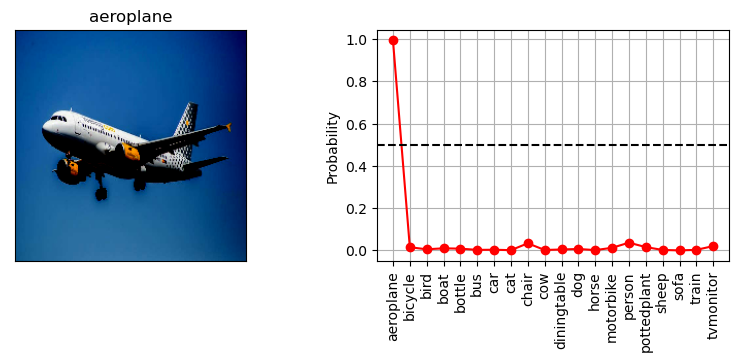

In [80]:
# Preprocess and predict:
preprocessed_image = preprocess(orig_image)
image_probs = classification_model.model.predict(preprocessed_image, verbose=False)[0]
# Get predicted label(s) and convert to string
pred_indices = np.argwhere(image_probs > 0.5)
pred_label = np.array(labels.tolist())[pred_indices].flatten()

# Print results
print(f"Correct   label(s): aeroplane")
print(f"Predicted label(s): {pred_label}")

# Plot image and prediction distribution
plt.subplots(1, 2, figsize=(10, 3))
plt.subplot(121)
plt.imshow(preprocessed_image[0])
plt.title("aeroplane")
plt.xticks([])
plt.yticks([])

# Plot distribution
plt.subplot(122)
xt = [i for i in range(len(image_probs))]
plt.plot(xt, image_probs, "-o", color="red")
plt.xticks(xt, labels=labels, rotation=90)
plt.ylabel("Probability")
plt.grid()
plt.axhline(0.5, ls="--", color="black")

plt.show()

## 4.2 Loss function and gradient for the attack

We will now start building our attack on the network. We implement the PGD, explained in detail above:

In [81]:
loss_fn = tf.keras.losses.BinaryCrossentropy()
def compute_gradient(input_image, target_label):
    """
    Computes the adversarial gradient that minimizes the loss from the image towards the target label.

    Args:
        input_image (tf.Tensor): Input image tensor.
        target_label (tf.Tensor): Target label tensor with shape (1, label_id).

    Returns:
        tf.Tensor: The adversarial gradient that minimizes the loss from the image towards the target label.
    """
    with tf.GradientTape() as tape:
        # Record the gradient operations happening inside this tape context
        tape.watch(input_image)
        
        # Forward pass
        prediction = classification_model.model(input_image)

        # We're trying to **minimize** the distance between the target (adversarial) label
        # and the predicted label, which is why we use a negative sign in the loss.
        # Note: Regularization is not added to the loss function here as we will be
        # regularizing the perturbation (the gradient) later on.
        loss = -loss_fn(target_label, prediction)

    # Backward pass
    # Compute the derivative of the loss with respect to the input image
    gradient = tape.gradient(loss, input_image)

    return gradient

In [82]:
def normalize_gradient(grad, alpha_norm):
    """
    Normalizes the gradient using L2 normalization along each dimension of the image.

    Args:
        grad (tf.Tensor): Input gradient tensor.
        alpha_norm (float): Scaling factor for the normalized perturbation.

    Returns:
        tf.Tensor: Normalized perturbation.
    """
    axis = list(range(1, len(grad.get_shape())))  # [1,2,3]

    # Separately normalize each gradient dimension of the image using the 'axis'
    optimal_perturbation = tf.math.l2_normalize(grad, axis=axis)

    return alpha_norm * optimal_perturbation

def projected_gradient_descent(image, alpha_norm, epochs, target_label):
    """
    Applies the projected gradient descent method to generate an adversarial image.

    Args:
        image (np.ndarray): Input image array.
        alpha_norm (float): Scaling factor for the normalized perturbation.
        epochs (int): Number of optimization steps.
        target_label (tf.Tensor): Target label tensor with shape (1, label_id).

    Returns:
        np.ndarray: Adversarial image generated by the projected gradient descent method.
        np.ndarray: Accumulated perturbation during the optimization process.
    """
    perturbation_sum = np.zeros(image.shape)

    img_delta = image

    for _ in range(epochs):
        grad = compute_gradient(img_delta, target_label)
        optimal_perturbation = normalize_gradient(grad, alpha_norm)
        img_delta = img_delta + optimal_perturbation

        perturbation_sum = perturbation_sum + optimal_perturbation

    return img_delta, perturbation_sum

In [83]:
def display_images(adversarial_image, description, perturbations, original_label, original_confidence):
    """Auxiliary function for plotting the adverserial attack for visualization."""
    origFigSize = plt.rcParams['figure.figsize']
    plt.rcParams['figure.figsize'] = [15, 3]
    plt.figure()

    # 1 - Original image
    plt.subplot(1,4,1)
    plt.imshow(*preprocessed_image)
    plt.title(f'Original \n {original_label} : {original_confidence}')
    plt.xticks([])
    plt.yticks([])
    
    # 2 - The perturbations
    plt.subplot(1,4,2)
    plt.imshow(*(perturbations*10))
    plt.title(f'{description}')
    plt.xticks([])
    plt.yticks([])

    # 3 - The adversarial image and predictions
    plt.subplot(1,4,3)
    plt.imshow(*(adversarial_image))
    plt.xticks([])
    plt.yticks([])

    # Get the prediction of the model for the title
    adv_image_probs = classification_model.model.predict(adversarial_image, verbose=0)[0]
    adv_pred_indices = np.argwhere(adv_image_probs > threshold)
    adv_image_probs = np.round(adv_image_probs, 2)
    adv_pred_label = np.array(labels.tolist())[adv_pred_indices].flatten() 
    plt.title(f'Adversarial \n {adv_pred_label} : {adv_image_probs[adv_pred_indices].flatten()}')
    
    # 4 - Show distributions
    plt.subplot(1,4,4)
    xt = [i for i in range(len(adv_image_probs))]
    plt.plot(xt, adv_image_probs, "-o", color="red")
    plt.xticks(xt, labels=labels, rotation=90)
    plt.ylabel("Probability")
    plt.grid()
    plt.axhline(0.5, ls="--", color="black")
    
    plt.show() 
    plt.rcParams['figure.figsize'] = origFigSize

In [84]:
NUM_CLASSES = 20
threshold = 0.5

# Get prediction labels
image_probs = classification_model.model.predict(preprocessed_image, verbose=False)[0]
pred_indices = np.argwhere(image_probs > threshold)
pred_label = np.array(labels.tolist())[pred_indices].flatten()
image_probs = np.round(image_probs, 2)


categ_encoder_layer = tf.keras.layers.CategoryEncoding(
          num_tokens=NUM_CLASSES, output_mode="multi_hot")

# Target labels are horse and person:
target_label = categ_encoder_layer([12, 14])

# Create a batch with a single image label
target_label = tf.reshape(target_label, (1, NUM_CLASSES))

## 4.3 Applying the adversarial attack

Now that we built the appropriate loss function and the PGD method, let's see how this perturbations affects the original image of the airplane and whether the changes are actually perceptible. The perturbations are magnified below for visualization purposes: we note that this does not mean that it is actually visible by humans when not magnified.

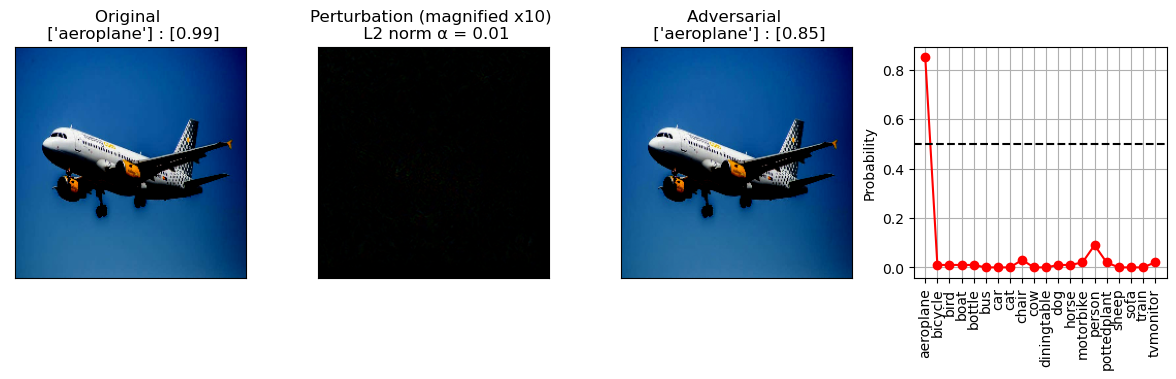

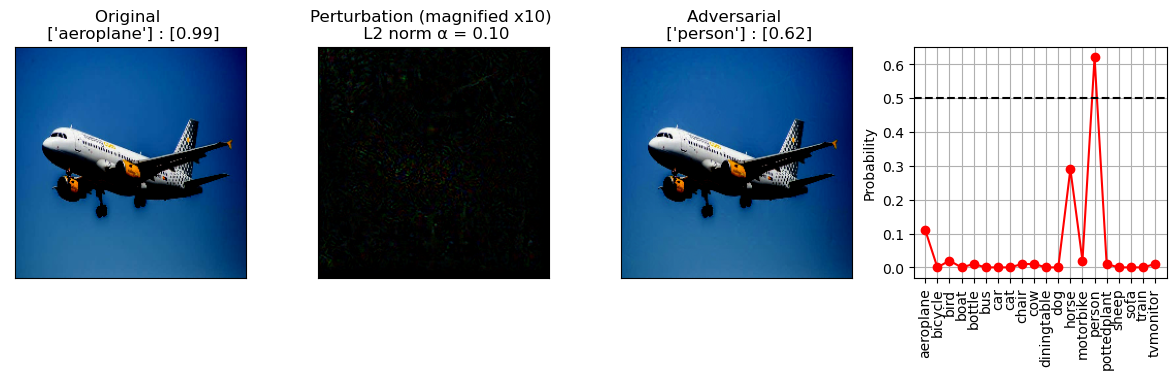

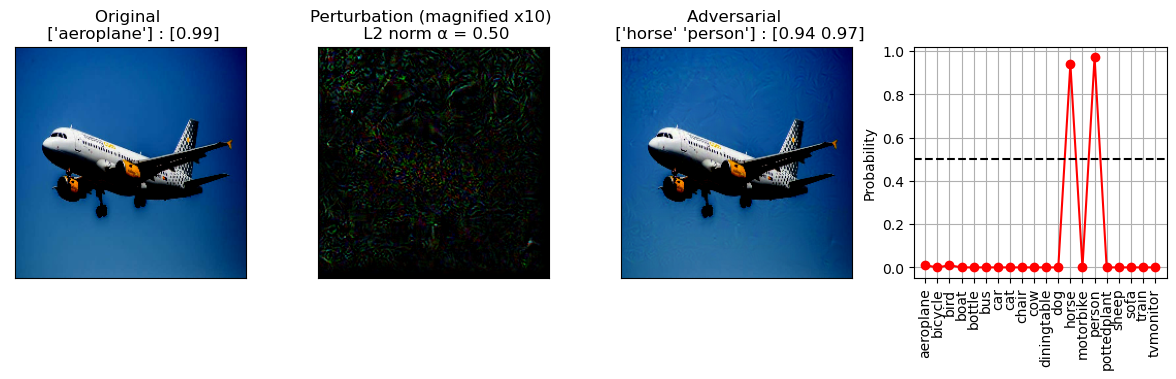

In [85]:
# Decrease me to hide the perturbation trading off target confidence
alphas = [0.01, 0.1, 0.5]
descriptions = [f'Perturbation (magnified x10) \n L2 norm α = {a:0.2f}' for a in alphas]

# Increase me to get a more accurate estimation of the perturbation
EPOCHS = 40

for i, eps in enumerate(alphas): 
    adv_x, perturbations = projected_gradient_descent(preprocessed_image, eps, EPOCHS, target_label)
    display_images(adv_x, descriptions[i], perturbations, str(pred_label), str(image_probs[pred_indices].flatten()))

## 4.4 Discussion

We now present a discussion regarding the adversarial attack we implemented.

One could ask **whether such a white-box attack is realistic**. While most models are currently released as black-box models, a possible leak of model weights (in the case of propietary models) or the increasing usage of open source models with pretrained weights would definitely pose a threat for the security of those systems. Once the attacker identified the model and weights used, the attacker would be able to replicate the enviroment and craft adversarial inputs such that systems, which are not designed to be protected against such attacks, would be vulnerable, even when sitting behind an opaque API. This is also really important now that larger models are being released and not everyone is capable (by money or time constraints) of retraining the weights. While adversarial attacks were discussed here in the context of computer vision, we note that similar dangers exist in other AI fields employing deep learning. Large language models can similarly be misused in case their weights are leaked, and [the leak of Meta's LLaMa model a few months ago](https://www.theverge.com/2023/3/8/23629362/meta-ai-language-model-llama-leak-online-misuse) demonstrates that such a scenario can be turned into a reality.

Coming back to our attack, the **adversary was successful** in perturbing the images such that they changed the prediction of the model to the deceptive label with almost $100\%$ confidence, while still being clearly recognisable for a human observer by the original class. 

We remark that this means that the initial CNN that we trained is in some sense **unreliable**. At least it demonstrates that we should not trust the CNN blindly, and while chances are small that real-life images will disrupt the CNN, one should be prepared in case such an event happens. For instance, if a similar CNN was trained in a medical environment, inaccurate predictions can have drastic consequences. However, we do note that such an environment is likely less threatened by actual adversarial *attacks*, since it is likely that such models are not publicly accessible and there are fewer cases where attackers could benefit from such an attack. Moreover, patients themselves benefit from the model and its predictions, so they are likely not going to try to attack the model. 

To **increase the robustness** of the CNN to protect it against attacks, we do not think that there is a practical defense against all possible attacks when the attacker has the model weights, but a deterrent would be to keep the weights as private as possible. This is a vulnerability shared by all machine learning models that learn by optimisation and can not be ascribed to metrics such as accuracy or any other performance measure. However, we can defend the model from transfer attacks where the attacker only has similar weights or the architecture of the model. There is also the adversarial accuracy metric that tests whether a datapoint and its neighbouring datapoints have a similar prediction as it would be harder to find an adversarial input that maximises the loss. Furthermore, there exist benchmarking datasets online, which we could use to get an idea of how vulnerable our system is, in case we wish to deploy the model in real-life applications.

# 5. Discussion
Finally, take some time to reflect on what you have learned during this assignment. Reflect and produce an overall discussion with links to the lectures and "real world" computer vision.

## 5.1 Classification

The starting point of the image classification section was to **choose an architecture** that would work properly for this specific problem. The established approach was to consider the models available in the Keras library, and benchmark some of them to see which one performs the best. The main factor for the decision was the combination of size of the model and the number of layers. We avoided those with large size and a high number of layers because the training data that we have is quite reduced, just 749 initial images to work with. If we used those, the training would have been slower, we might have come across out-of-memory issues and smaller networks tend to better describe smaller sets of data. That is why we opted for models with low-medium size and a decent number of layers like Xception, InceptionV3, MobileNet or MobileNetV2 and VGG16, which is really heavy but just has 16 layers. It would have been possible to try even more architectures, but since time was limited, we focused on those. Instead, we focused on improving the way we train these smaller networks.

The choice of cross-entropy as the **loss function** is already explained in its correspondent section, but there was a moment in which we had to decide between binary cross-entropy or categorical cross-entropy. Even though this last one sounded better for the problem we were facing, it works better when you have one-hot vectors as predictions. Since our prediction vectors can have more than one "1" value because it is a multi-label problem, it was decided to go for binary cross-entropy instead. Related to this, for the metrics used during training we developed our own keras.Metric since the accuracies provided by keras.metrics weren't working as we wanted due to the same issue with the format of the labels. Moving on to the learning parameters, we started with a standard value for the learning rate with $10^-5$. From that, we did an oriented but general **hyperparameter search** that led us to use $10^-3$ for models with just transfer learning and $10^-4$ + $10^-7$ for those that also got fine-tuned and for those in which the weights had to be learned from scratch. In a similar fashion as the models themselves, with more time we search would have been more exhaustive, but the overall results were already decent with the ones finally used. When it comes to batch size, we used batches of 32 whenever possible since larger batches would cause out-of-memory issues on some architectures. This value was only changed for architectures which we trained from scratch, because they needed more epochs to train until convergence and if maintained the same learning rate, it would have been too slow. 

Even with all these features, the main problem we faced was **overfitting** in all three training procedures. However, we noticed that the performance of architectures trained with transfer learning and fine-tuning have a much higher accuracy compared to models trained from scratch, clearly showing the benefit of pretrained models which have layers capable of extracting rich and abstract feature representations, which turned out to be also useful for our dataset. Training architectures from scratch is clearly incapable of achieving a similar performance. 

About **further extensions** of our code, we implemented functions to perform basic **data augmentation** to increase the number of training images to try and improve our results. We created an augmentation function that, using the tools TensorFlow provides in tf.image, would create two additional images from an original one mainly playing with random values of contrast, saturation and brightness. By doing so, we would have training images instead of just. And just in case it didn't work, we also implemented another more drastic function where we would randomly generate between 1 and 4 additional images per original one with flipping techniques apart from the previously mentioned parameters. However, since the final models already achieved great results and no significant improvements were observed with this in terms of accuracy, we did not include the preprocessing here to save space and to prevent out-of-memory issues for the final notebook. Also, we could implement a weighted loss function to take the imbalanced data into account in the future. However, this will also provide only marginal improvements.  

## 5.2 Segmentation

**TODO**

As we will discuss later the higher problem faced on the training of semantic segmentation models was the **imbalanced dataset**. We have plotted a graph showing the distribution of the classes for the segmentation task, which clearly showed that the background class had a much higher weight. The reason is that, naturally, the background is present in all images and moreover with a much higher percentage compared to the actual objects. 

As a consequence of this imbalance, training leads to a large divergence between traininig and validation accuracy implying that the models have a hard time to generalize to unseen data, likely since they tend to predict the background class most of the times. It results in pixels being classified as multiple classes. This behaviour is expected on an imbalance dataset, because the model realize that the percentage of error when it assign background to a pixel is very low, only for a few ones (the objects) it is doing wrong. Therefore at the beginning of the training it is simply limited to predict always background, until a number of epochs that it starts predicting some points as differen. However as the difference between the number of samples for any other class is much lower than the smaples for background it struggles finding patters to realized which one of them it is. As the number of epochs start increising, the model learn how to find some of the classes presented on the training data, leading to overfitting. This overfitting drives the accuracy to a large divergence between training and validation.

To improve the model behaviour different preprocessings has been applied to the training data. Therefore the studied of this training process can be divided on different phases:

No previous preprocesing: On this phase the model was trained with data which was only normalized and resized during its preprocessing.
Cropping the data: In order to balanced the number of pixels in each class, a cropping to remove some part of the backgroung was done in the preprocessing part.
Augmentation: the training dataset was increased by the use of agmentation data, where the images where flip or rotate.
Weight loss: To compensate the effect of the imbalance data, a unbalance weight estimation was done and was added to the loss function to punish the prediction of background.

Due to the imbalanced dataset, as discussed in Section 5, we tried different training set-ups that try to solve this issue. We considered:

1. **No previous preprocesing**: the model is trained with data which was only normalized and resized during its preprocessing. 
2. **Cropping the data**: to balance the number of pixels in each class, we crop images to remove some part of the background during the preprocessing. 
3. **Augmentation**: the training dataset was increased by the use of agmentatqtion data, where the images where randomly flipped or rotated. 
4. **Weight loss**: To compensate the effect of the imbalance data, samples are assigned weights which modify the loss function to penalize the models from predicting the background on an object's pixel.

## 5.3 Adversarial attack

# A. Classification models

Here, we provide the complete code that we used to compare different classification models. This appendix is divided into four parts, related to the different architectures (the architectures were discussed at the beginning of Section 2):
1. MobileNetV2 (Section A.1)
2. VGG16 (Section A.2)
3. InceptionV3 (Section A.3)
4. Xception (Section A.4)
5. MobileNet (Section A.5)
6. Comparison between different architectures

Each section is further subdivided into three subsections, which are related to the different training mechanisms that we considered:

1. Transfer learning (Section A.X.1)
2. Transfer learning with fine-tuning (Section A.X.2)
3. Training the weights from scratch (Section A.X.3)

The specific architecture designs are shown at the beginning of each subsection. The details of the training, hyperparameter selection and a comparison between the training methods are discussed in Section A.1 for the MobileNetV2 architecture. The other sections make use of very similar set-ups and hyperparameter settings, so we only provide the necessary code there and readers are encouraged to read through Section A.1 for explanation. 

## A.1 MobileNetV2

### A.1.1 Transfer learning

In [34]:
SAVE_LOCATION = "/kaggle/working/mobv2_m1_best.h5"

class MobileNetV2_Model:
    """
    A class representing a MobileNetV2 model for image classification.

    Attributes
    ----------
    model : tf.keras.Model
        The MobileNetV2 model.

    Methods
    -------
    __init__()
        Initializes the MobileNetV2 model.
    fit(X, y)
        Trains the MobileNetV2 model with training images X and labels y.
    predict(X)
        Performs predictions using the MobileNetV2 model.
    __call__(X)
        Calls the predict() method.

    """
    def __init__(self):
        """
        Initializes the MobileNetV2 model.

        This function constructs a MobileNetV2 model with pre-trained weights from ImageNet.
        The fully connected layers of the original model are replaced with a new flattened layer
        and a dense layer with 20 units and sigmoid activation.

        """
        # Load in the MobileNetV2 architecture from Keras, use weights from Imagenet
        mobv2_model = tf.keras.applications.MobileNetV2(
            include_top=False,
            input_shape=(224, 224, 3),
            weights="imagenet"
        )

        # Freeze all layers of the MobileNetV2 model
        for l in mobv2_model.layers:
            l.trainable = False

        # Add new layer on top of the MobileNetV2 model to process our dataset
        new_l = tf.keras.layers.Flatten()(mobv2_model.output)
        new_l = tf.keras.layers.Dense(20, activation='sigmoid')(new_l)

        # Create a new model with the modified layers
        self.model = tf.keras.Model(inputs=mobv2_model.input, outputs=new_l)
        
    def fit(self, X, y):
        """
        Trains the MobileNetV2 model.

        Parameters
        ----------
        X : np.array
            The input images as a numpy array with shape (num_samples, height, width, channels).
        y : np.array
            The target labels as a numpy array with shape (num_samples, num_classes).

        """
        X_train = tf.keras.applications.mobilenet_v2.preprocess_input(X)

        # Compile the model with settings for optimization and loss calculation
        self.model.compile(
            run_eagerly=True,
            optimizer=tf.keras.optimizers.Adam(1e-3),
            loss="binary_crossentropy",
            metrics=[tf.keras.metrics.FalseNegatives(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), AdaptedAccuracy()]
        )

        # Set up callbacks for early stopping and saving the best model
        callbacks = [
            tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, min_delta=0.01),
            tf.keras.callbacks.ModelCheckpoint(
                filepath=SAVE_LOCATION,
                monitor="val_loss",
                save_best_only=True
            )
        ]

        # Train the model
        history = self.model.fit(
            X_train, y,
            epochs=30,
            batch_size=32,
            validation_split=0.25,
            callbacks=callbacks
        )
        
         # Store the information obtained during training as field
        self.history = history

    def predict(self, X):
        """
        Performs predictions using the MobileNetV2 model.

        Parameters
        ----------
        X : np.array
            The input images as a numpy array with shape (num_samples, height, width, channels).

        Returns
        -------
        np.array
            The predicted class probabilities as a numpy array with shape (num_samples, num_classes).

        """
        preprocessed_X = tf.keras.applications.mobilenet_v2.preprocess_input(X)
        return self.model.predict(X, verbose=0)

    def __call__(self, X):
        """
        Calls the predict() method.

        Parameters
        ----------
        X : np.array
            The input images as a numpy array with shape (num_samples, height, width, channels).

        Returns
        -------
        np.array
            The predicted class probabilities as a numpy array with shape (num_samples, num_classes).

        """
        preprocessed_X = tf.keras.applications.mobilenet_v2.preprocess_input(X)
        return self.model.predict(X, verbose=0)

Now, define a new instance of the model, and train it on the Pascal VOC dataset:

In [87]:
if TRAIN_MODELS:
    # Define an instance:
    mobv2_m1 = MobileNetV2_Model()
    ## Show complete architecture -- lengthy output!
    # mobv2_m1.model.summary()
    # Train on Pascal VOC dataset
    mobv2_m1.fit(X_train, y_train)
    # Visualize the learning curves
    show_training(mobv2_m1.history.history, acc_key="adapted_accuracy")

### A.1.2 Transfer learning and finetuning

In [38]:
SAVE_LOCATION = "/kaggle/working/mobv2_m2_best.h5"

class MobileNetV2_fine_Model:
    """
    A class representing a fine-tuned MobileNetV2 model for image classification.

    Attributes
    ----------
    model : tf.keras.Model
        The fine-tuned MobileNetV2 model.

    Methods
    -------
    __init__(X, y)
        Initializes and trains the fine-tuned MobileNetV2 model.
    predict(X)
        Performs predictions using the fine-tuned MobileNetV2 model.
    __call__(X)
        Calls the predict() method.

    """

    def __init__(self, X, y):
        """
        Initializes and trains the fine-tuned MobileNetV2 model.

        Parameters
        ----------
        X : np.array
            The input images as a numpy array with shape (num_samples, height, width, channels).
        y : np.array
            The target labels as a numpy array with shape (num_samples, num_classes).

        """
        base_model = tf.keras.applications.MobileNetV2(
            include_top=False,
            input_shape=(224, 224, 3),
            weights="imagenet"
        )

        # Freeze all layers of the base MobileNetV2 model
        base_model.trainable = False

        # Add new layers on top of the base model
        new_l = tf.keras.layers.Flatten()(base_model.output)
        new_l = tf.keras.layers.Dense(20, activation="sigmoid")(new_l)

        # Create the new model with the modified layers
        model = tf.keras.Model(base_model.input, new_l)

        X_train = tf.keras.applications.mobilenet_v2.preprocess_input(X)

        # Compile and train the model with the first set of hyperparameters
        model.compile(
            run_eagerly=True,
            optimizer=tf.keras.optimizers.Adam(1e-4),
            loss='binary_crossentropy',
            metrics=[tf.keras.metrics.FalseNegatives(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), AdaptedAccuracy()]
        )
        
        callbacks = [
            tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, min_delta=0.01),
            tf.keras.callbacks.ModelCheckpoint(
                filepath=SAVE_LOCATION,
                monitor="val_loss",
                save_best_only=True
            )
        ]

        pre_history = model.fit(
            X_train, y,
            epochs=30,
            batch_size=32,
            validation_split=0.25,
            callbacks=callbacks
        )

        # Allow ALL layers of the base model to be trainable
        base_model.trainable = True

        # Compile and train the model with the second set of hyperparameters
        model.compile(
            run_eagerly=True,
            optimizer=tf.keras.optimizers.Adam(1e-7),
            loss='binary_crossentropy',
            metrics=[tf.keras.metrics.FalseNegatives(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), AdaptedAccuracy()]
        )

        history = model.fit(
            X_train, y,
            epochs=30,
            batch_size=32,
            validation_split=0.25,
            callbacks=callbacks
        )

        self.model = model
        self.pre_history = pre_history
        self.history = history

    def predict(self, X):
        """
        Performs predictions using the fine-tuned MobileNetV2 model.

        Parameters
        ----------
        X : np.array
            The input images as a numpy array with shape (num_samples, height, width, channels).

        Returns
        -------
        np.array
            The predicted class probabilities as a numpy array with shape (num_samples, num_classes).

        """
        preprocessed_X = tf.keras.applications.mobilenet_v2.preprocess_input(X)
        return self.model.predict(preprocessed_X, verbose=0)

    def __call__(self, X):
        """
        Calls the predict() method.

        Parameters
        ----------
        X : np.array
            The input images as a numpy array with shape (num_samples, height, width, channels).

        Returns
        -------
        np.array
            The predicted class probabilities as a numpy array with shape (num_samples, num_classes).

        """
        preprocessed_X = tf.keras.applications.mobilenet_v2.preprocess_input(X)
        return self.model.predict(preprocessed_X, verbose=0)

In [89]:
if TRAIN_MODELS:
    mobv2_m2 = MobileNetV2_fine_Model(X_train, y_train)
    show_training(mobv2_m2.pre_history.history, acc_key="adapted_accuracy")
    show_training(mobv2_m2.history.history, acc_key="adapted_accuracy")

### A.1.3 Training from scratch

In [39]:
SAVE_LOCATION = "/kaggle/working/mobv2_m3_best.h5"

class MobileNetV2_scratch_Model:
    """
    A class representing a MobileNetV2 model trained from scratch for image classification.

    Attributes
    ----------
    model : tf.keras.Model
        The MobileNetV2 model trained from scratch.

    Methods
    -------
    __init__()
        Initializes the MobileNetV2 model trained from scratch.
    fit(X, y)
        Trains the MobileNetV2 model on the given dataset.
    predict(X)
        Performs predictions using the MobileNetV2 model.
    __call__(X)
        Calls the predict() method.

    """

    def __init__(self):
        """
        Initializes the MobileNetV2 model trained from scratch.

        """
        mobv2_model = tf.keras.applications.MobileNetV2(
            include_top=False,
            input_shape=(224, 224, 3),
            weights=None
        )

        # Add new layers on top of the MobileNetV2 model
        new_l = tf.keras.layers.Flatten()(mobv2_model.output)
        new_l = tf.keras.layers.Dense(20, activation="sigmoid")(new_l)

        # Create the model with the modified layers
        self.model = tf.keras.Model(inputs=mobv2_model.input, outputs=new_l)
        
        
    def fit(self, X, y):
        """
        Trains the MobileNetV2 model on the given dataset.

        Parameters
        ----------
        X : np.array
            The input images as a numpy array with shape (num_samples, height, width, channels).
        y : np.array
            The target labels as a numpy array with shape (num_samples, num_classes).

        """
        X_train = tf.keras.applications.mobilenet_v2.preprocess_input(X)

        self.model.compile(
            run_eagerly=True,
            optimizer=tf.keras.optimizers.Adam(0.5),
            loss='binary_crossentropy',
            metrics=[tf.keras.metrics.FalseNegatives(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), AdaptedAccuracy()]
        )

        callbacks = [
            tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, min_delta=0.01),
            tf.keras.callbacks.ModelCheckpoint(
                filepath=SAVE_LOCATION,
                monitor="val_loss",
                save_best_only=True
            )
        ]

        history = self.model.fit(
            X_train, y,
            epochs=200,
            batch_size=64,
            validation_split=0.25,
            callbacks=callbacks
        )
        
        self.history = history

    def predict(self, X):
        """
        Performs predictions using the MobileNetV2 model.

        Parameters
        ----------
        X : np.array
            The input images as a numpy array with shape (num_samples, height, width, channels).

        Returns
        -------
        np.array
            The predicted class probabilities as a numpy array with shape (num_samples, num_classes).

        """
        preprocessed_X = tf.keras.applications.mobilenet_v2.preprocess_input(X)
        return self.model.predict(preprocessed_X, verbose=0)
    
    def __call__(self, X):
        """
        Calls the predict() method.

        Parameters
        ----------
        X : np.array
            The input images as a numpy array with shape (num_samples, height, width, channels).

        Returns
        -------
        np.array
            The predicted class probabilities as a numpy array with shape (num_samples, num_classes).

        """
        return self.predict(X)

In [91]:
if TRAIN_MODELS:
    mobv2_m3 = MobileNetV2_scratch_Model()
    mobv2_m3.fit(X_train, y_train)
    show_training(mobv2_m3.history.history, acc_key = "adapted_accuracy")

## A.2 VGG16

### A.2.1 Transfer learning

In [40]:
SAVE_LOCATION = "/kaggle/working/vgg_m1_best.h5"

class VGG16_Model:
    def __init__(self):
        vgg_model = tf.keras.applications.VGG16(
            include_top=False,
            input_shape=(224, 224, 3),
            weights="imagenet"
        )

        # Freeze the layers of the VGG16 model
        for l in vgg_model.layers:
            l.trainable = False

        # Add new layers on top of the VGG16 model
        new_l = tf.keras.layers.Flatten()(vgg_model.output)
        new_l = tf.keras.layers.Dense(20, activation="sigmoid")(new_l)

        # Create the model with the modified layers
        self.model = tf.keras.Model(inputs=vgg_model.input, outputs=new_l)

    def fit(self, X, y):
        X_train = tf.keras.applications.vgg16.preprocess_input(X)

        self.model.compile(
            run_eagerly=True,
            optimizer=tf.keras.optimizers.Adam(1e-3),
            loss='binary_crossentropy',
            metrics=[tf.keras.metrics.FalseNegatives(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), AdaptedAccuracy()]
        )

        callbacks = [
            tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, min_delta=0.01),
            tf.keras.callbacks.ModelCheckpoint(
                filepath=SAVE_LOCATION,
                monitor="val_loss",
                save_best_only=True
            )
        ]

        history = self.model.fit(
            X_train, y,
            epochs=30,
            batch_size=32,
            validation_split=0.25,
            callbacks=callbacks
        )
        
        self.history = history

    def predict(self, X):
        preprocessed_X = tf.keras.applications.vgg16.preprocess_input(X)
        return self.model.predict(preprocessed_X, verbose=0)

    def __call__(self, X):
        return self.predict(X)

In [93]:
if TRAIN_MODELS:
    vgg_m1 = VGG16_Model()
    vgg_m1.fit(X_train, y_train)
    show_training(vgg_m1.history.history, acc_key="adapted_accuracy")

### A.2.2 Transfer learning with fine-tuning

In [41]:
SAVE_LOCATION = "/kaggle/working/vgg_m2_best.h5"

class VGG16_fine_Model:
    def __init__(self, X, y):
        base_model = tf.keras.applications.VGG16(
            include_top=False,
            input_shape=(224, 224, 3),
            weights="imagenet"
        )

        # Freeze the layers of the VGG16 base model
        base_model.trainable = False

        # Add new layers on top of the VGG16 base model
        new_l = tf.keras.layers.Flatten()(base_model.output)
        new_l = tf.keras.layers.Dense(20, activation="sigmoid")(new_l)

        # Create the model with the modified layers
        model = tf.keras.Model(inputs=base_model.input, outputs=new_l)

        X_train = tf.keras.applications.vgg16.preprocess_input(X)

        model.compile(
            run_eagerly=True,
            optimizer=tf.keras.optimizers.Adam(1e-4),
            loss='binary_crossentropy',
            metrics=[tf.keras.metrics.FalseNegatives(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), AdaptedAccuracy()]
        )

        callbacks = [
            tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, min_delta=0.01),
            tf.keras.callbacks.ModelCheckpoint(
                filepath=SAVE_LOCATION,
                monitor="val_loss",
                save_best_only=True
            )
        ]

        pre_history = model.fit(
            X_train, y,
            epochs=30,
            batch_size=32,
            validation_split=0.25,
            callbacks=callbacks
        )

        # Enable training of all layers in the VGG16 model
        base_model.trainable = True

        model.compile(
            run_eagerly=True,
            optimizer=tf.keras.optimizers.Adam(1e-7),
            loss='binary_crossentropy',
            metrics=[tf.keras.metrics.FalseNegatives(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), AdaptedAccuracy()]
        )

        history = model.fit(
            X_train, y,
            epochs=30,
            batch_size=32,
            validation_split=0.25,
            callbacks=callbacks
        )

        self.model = model
        self.pre_history = pre_history
        self.history = history
        
    def predict(self, X):
        return self.model.predict(preprocessed_X, verbose=0)

    def __call__(self, X):
        return self.predict(X)

In [95]:
if TRAIN_MODELS:
    vgg_m2 = VGG16_fine_Model(X_train, y_train)
    show_training(vgg_m2.pre_history.history, acc_key="adapted_accuracy")
    show_training(vgg_m2.history.history, acc_key="adapted_accuracy")

### A.2.3 Training from scratch

In [42]:
SAVE_LOCATION = "/kaggle/working/vgg_m3_best.h5"

class VGG16_scratch_Model:
    def __init__(self):
        vgg_model = tf.keras.applications.VGG16(include_top=False, input_shape=(224,224,3), weights=None)
        new_l = tf.keras.layers.Flatten()(vgg_model.output)
        new_l = tf.keras.layers.Dense(20, activation="sigmoid")(new_l)
        self.model = tf.keras.Model(inputs=vgg_model.input, outputs=new_l)

    def fit(self, X, y):
        X_train = tf.keras.applications.vgg16.preprocess_input(X)
        self.model.compile(run_eagerly=True, optimizer=tf.keras.optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=[tf.keras.metrics.FalseNegatives(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), AdaptedAccuracy()])
        callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, min_delta=0.01),
                     tf.keras.callbacks.ModelCheckpoint(filepath=SAVE_LOCATION, monitor="val_loss", save_best_only=True)]
        history = self.model.fit(X_train, y, epochs=200, batch_size=64, validation_split=0.25, callbacks=callbacks)
        self.history = history

    def predict(self, X):
        return self.model.predict(tf.keras.applications.vgg16.preprocess_input(X), verbose=0)

    def __call__(self, X):
        return self.predict(X)

In [97]:
if TRAIN_MODELS:
    vgg_m3 = VGG16_scratch_Model()
    vgg_m3.fit(X_train, y_train)
    show_training(vgg_m3.history.history, acc_key="adapted_accuracy")

## A.3 InceptionV3

### A.3.1 Transfer learning

In [43]:
SAVE_LOCATION = "/kaggle/working/incv3_m1_best.h5"

class InceptionV3_Model:
    def __init__(self):
        incv3_model = tf.keras.applications.InceptionV3(include_top=False, input_shape=(224,224,3), weights="imagenet")
        for l in incv3_model.layers:
            l.trainable = False
        new_l = tf.keras.layers.Flatten()(incv3_model.output)
        new_l = tf.keras.layers.Dense(20, activation="sigmoid")(new_l)
        self.model = tf.keras.Model(inputs=incv3_model.input, outputs=new_l)

    def fit(self, X, y):
        X_train = tf.keras.applications.inception_v3.preprocess_input(X)
        self.model.compile(run_eagerly=True, optimizer=tf.keras.optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=[tf.keras.metrics.FalseNegatives(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), AdaptedAccuracy()])
        callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, min_delta=0.01),
                     tf.keras.callbacks.ModelCheckpoint(filepath=SAVE_LOCATION, monitor="val_loss", save_best_only=True)]
        history = self.model.fit(X_train, y, epochs=30, batch_size=32, validation_split=0.25, callbacks=callbacks)
        self.history = history

    def predict(self, X):
        return self.model.predict(tf.keras.applications.inception_v3.preprocess_input(X), verbose=0)

    def __call__(self, X):
        return self.predict(X)

In [99]:
if TRAIN_MODELS:
    incv3_m1 = InceptionV3_Model()
    incv3_m1.fit(X_train, y_train)
    show_training(incv3_m1.history.history, acc_key="adapted_accuracy")

### A.3.2 Transfer learning and fine-tuning

In [44]:
SAVE_LOCATION = "/kaggle/working/incv3_m2_best.h5"

class InceptionV3_fine_Model:
    def __init__(self, X, y):
        base_model = tf.keras.applications.InceptionV3(include_top=False, input_shape=(224,224,3), weights="imagenet")
        base_model.trainable = False

        new_l = tf.keras.layers.Flatten()(base_model.output)
        new_l = tf.keras.layers.Dense(20, activation="sigmoid")(new_l)
        model = tf.keras.Model(base_model.input, new_l)

        X_train = tf.keras.applications.inception_v3.preprocess_input(X)

        model.compile(run_eagerly=True, optimizer=tf.keras.optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=[tf.keras.metrics.FalseNegatives(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), AdaptedAccuracy()])
        callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, min_delta=0.01),
                     tf.keras.callbacks.ModelCheckpoint(filepath=SAVE_LOCATION, monitor="val_loss", save_best_only=True)]
        pre_history = model.fit(X_train, y, epochs=30, batch_size=32, validation_split=0.25, callbacks=callbacks)
        self.pre_history = pre_history

        base_model.trainable = True
        model.compile(run_eagerly=True, optimizer=tf.keras.optimizers.Adam(1e-7), loss='binary_crossentropy', metrics=[tf.keras.metrics.FalseNegatives(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), AdaptedAccuracy()])
        history = model.fit(X_train, y, epochs=30, batch_size=32, validation_split=0.25, callbacks=callbacks)
        self.model = model
        self.history = history

    def predict(self, X):
        return self.model.predict(tf.keras.applications.inception_v3.preprocess_input(X), verbose=0)

    def __call__(self, X):
        return self.predict(X)

In [101]:
if TRAIN_MODELS:
    incv3_m2 = InceptionV3_fine_Model(X_train, y_train)
    show_training(incv3_m2.history.history, acc_key="adapted_accuracy")
    show_training(incv3_m2.history.history, acc_key="adapted_accuracy")

### A.3.3 Training from scratch

In [45]:
SAVE_LOCATION = "/kaggle/working/incv3_m3_best.h5"

class InceptionV3_scratch_Model:

    def __init__(self):
        incv3_model = tf.keras.applications.InceptionV3(include_top=False, input_shape=(224,224,3), weights=None)
        new_l = tf.keras.layers.Flatten()(incv3_model.output)
        new_l = tf.keras.layers.Dense(20, activation="sigmoid")(new_l)
        self.model = tf.keras.Model(inputs=incv3_model.input, outputs=new_l)

    def fit(self, X, y):
        X_train = tf.keras.applications.inception_v3.preprocess_input(X)
        self.model.compile(run_eagerly=True, optimizer=tf.keras.optimizers.Adam(0.5), loss='binary_crossentropy', metrics=[tf.keras.metrics.FalseNegatives(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), AdaptedAccuracy()])
        callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, min_delta=0.01),
                     tf.keras.callbacks.ModelCheckpoint(filepath=SAVE_LOCATION, monitor="val_loss", save_best_only=True)]
        history = self.model.fit(X_train, y, epochs=200, batch_size=64, validation_split=0.25, callbacks=callbacks)
        self.history = history

    def predict(self, X):
        return self.model.predict(tf.keras.applications.inception_v3.preprocess_input(X), verbose=0)

    def __call__(self, X):
        return self.predict(X)

In [103]:
if TRAIN_MODELS:
    incv3_m3 = InceptionV3_scratch_Model()
    incv3_m3.fit(X_train, y_train)
    show_training(incv3_m3.history.history, acc_key="adapted_accuracy")

## A.4 Xception

### A.4.1 Transfer learning

In [46]:
SAVE_LOCATION = "/kaggle/working/ex_m1_best.h5"

class XceptionModel1:

    def __init__(self):
        new_model = tf.keras.applications.Xception(include_top=False, input_shape=(299,299,3), weights="imagenet")
        for l in new_model.layers:
            l.trainable = False
        new_l = tf.keras.layers.Flatten()(new_model.output)
        new_l = tf.keras.layers.Dense(20, activation="sigmoid")(new_l)
        self.model = tf.keras.Model(inputs=new_model.input, outputs=new_l)

    def fit(self, X, y):
        X_train = tf.keras.applications.xception.preprocess_input(X)
        self.model.compile(run_eagerly=True, optimizer=tf.keras.optimizers.Adam(1e-3), loss='binary_crossentropy',
                           metrics=[tf.keras.metrics.FalseNegatives(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), AdaptedAccuracy()])
        callbacks = [
            tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3),
            tf.keras.callbacks.ModelCheckpoint(filepath=SAVE_LOCATION, monitor="val_loss", save_best_only=True)
        ]
        return self.model.fit(X_train, y, epochs=30,
                       batch_size=16, validation_split=0.25, callbacks=callbacks)

    def predict(self, X):
        return self.model.predict(tf.keras.applications.xception.preprocess_input(X), verbose=0)

    def __call__(self, X):
        return self.predict(X)

In [105]:
if TRAIN_MODELS:
    xception_model1 = XceptionModel1()
    history_xception = xception_model1.fit(X_train_big, y_train)

### A.4.2 Transfer learning and fine-tuning

In [47]:
SAVE_LOCATION = "/kaggle/working/ex_m2_best.h5"

class Xception_fine_Model:
    def __init__(self, X, y):
        base_model = tf.keras.applications.Xception(include_top=False, input_shape=(299,299,3), weights="imagenet")
        base_model.trainable = False

        new_l = tf.keras.layers.Flatten()(base_model.output)
        new_l = tf.keras.layers.Dense(20, activation="sigmoid")(new_l)
        model = tf.keras.Model(base_model.input, new_l)

        X_train = tf.keras.applications.xception.preprocess_input(X)

        model.compile(run_eagerly=True, optimizer=tf.keras.optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=[tf.keras.metrics.FalseNegatives(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), AdaptedAccuracy()])
        callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, min_delta=0.01),
                     tf.keras.callbacks.ModelCheckpoint(filepath=SAVE_LOCATION, monitor="val_loss", save_best_only=True)]
        pre_history = model.fit(X_train, y, epochs=30, batch_size=16, validation_split=0.25, callbacks=callbacks)
        self.pre_history = pre_history

        base_model.trainable = True
        model.compile(run_eagerly=True, optimizer=tf.keras.optimizers.Adam(1e-7), loss='binary_crossentropy', metrics=[tf.keras.metrics.FalseNegatives(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), AdaptedAccuracy()])
        history = model.fit(X_train, y, epochs=30, batch_size=16, validation_split=0.25, callbacks=callbacks)
        self.model = model
        self.history = history

    def predict(self, X):
        return self.model.predict(tf.keras.applications.xception.preprocess_input(X), verbose=0)

    def __call__(self, X):
        return self.predict(X)

In [107]:
if TRAIN_MODELS:
    xception_model2 = Xception_fine_Model(X_train_big, y_train)

### A.4.3 Training from scratch 

In [48]:
SAVE_LOCATION = "/kaggle/working/ex_m3_best.h5"

class Xception_scratch_Model:

    def __init__(self):
        incv3_model = tf.keras.applications.Xception(include_top=False, input_shape=(299,299,3), weights=None)
        new_l = tf.keras.layers.Flatten()(incv3_model.output)
        new_l = tf.keras.layers.Dense(20, activation="sigmoid")(new_l)
        self.model = tf.keras.Model(inputs=incv3_model.input, outputs=new_l)

    def fit(self, X, y):
        X_train = tf.keras.applications.xception.preprocess_input(X)
        self.model.compile(run_eagerly=True, optimizer=tf.keras.optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=[tf.keras.metrics.FalseNegatives(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), AdaptedAccuracy()])
        callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, min_delta=0.01),
                     tf.keras.callbacks.ModelCheckpoint(filepath=SAVE_LOCATION, monitor="val_loss", save_best_only=True)]
        history = self.model.fit(X_train, y, epochs=200, batch_size=16, validation_split=0.25, callbacks=callbacks)
        self.history = history

    def predict(self, X):
        return self.model.predict(tf.keras.applications.xception.preprocess_input(X), verbose=0)

    def __call__(self, X):
        return self.predict(X)

In [109]:
if TRAIN_MODELS:
    xception_model3 = Xception_scratch_Model()
    history_xception_3 = xception_model3.fit(X_train_big, y_train)

## A.5 MobileNet

### A.5.1 Transfer learning

In [49]:
SAVE_LOCATION = "/kaggle/working/mobv1_m1_best.h5"

class MobileNet_Model:
    def __init__(self):
        mob_model = tf.keras.applications.MobileNet(include_top=False, input_shape=(224,224,3), weights="imagenet")
        for l in mob_model.layers:
            l.trainable = False
        new_l = tf.keras.layers.Flatten()(mob_model.output)
        new_l = tf.keras.layers.Dense(20, activation="sigmoid")(new_l)
        self.model = tf.keras.Model(inputs=mob_model.input, outputs=new_l)

    def fit(self, X, y):
        X_train = tf.keras.applications.mobilenet.preprocess_input(X)
        self.model.compile(run_eagerly=True, optimizer=tf.keras.optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=[tf.keras.metrics.FalseNegatives(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), AdaptedAccuracy()])
        callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, min_delta=0.01),
                     tf.keras.callbacks.ModelCheckpoint(filepath=SAVE_LOCATION, monitor="val_loss", save_best_only=True)]
        history = self.model.fit(X_train, y, epochs=30, batch_size=32, validation_split=0.25, callbacks=callbacks)
        self.history = history

    def predict(self, X):
        return self.model.predict(tf.keras.applications.mobilenet.preprocess_input(X), verbose=0)

    def __call__(self, X):
        return self.predict(X)

In [111]:
if TRAIN_MODELS:
    mob_m1 = MobileNet_Model()
    mob_m1.fit(X_train, y_train)
    show_training(mob_m1.history.history, acc_key="adapted_accuracy")

### A.5.2 Transfer learning and fine-tuning

In [50]:
SAVE_LOCATION = "/kaggle/working/mobv1_m2_best.h5"

class MobileNet_fine_Model:

    def __init__(self, X, y):
        base_model = tf.keras.applications.MobileNet(include_top=False, input_shape=(224,224,3), weights="imagenet")
        base_model.trainable = False

        new_l = tf.keras.layers.Flatten()(base_model.output)
        new_l = tf.keras.layers.Dense(20, activation="sigmoid")(new_l)
        model = tf.keras.Model(base_model.input, new_l)

        X_train = tf.keras.applications.mobilenet.preprocess_input(X)

        model.compile(run_eagerly=True, optimizer=tf.keras.optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=[tf.keras.metrics.FalseNegatives(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), AdaptedAccuracy()])
        callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, min_delta=0.01),
                     tf.keras.callbacks.ModelCheckpoint(filepath=SAVE_LOCATION, monitor="val_loss", save_best_only=True)]
        pre_history = model.fit(X_train, y, epochs=30, batch_size=32, validation_split=0.25, callbacks=callbacks)
        self.pre_history = pre_history

        base_model.trainable = True
        model.compile(run_eagerly=True, optimizer=tf.keras.optimizers.Adam(1e-7), loss='binary_crossentropy', metrics=[tf.keras.metrics.FalseNegatives(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), AdaptedAccuracy()])
        history = model.fit(X_train, y, epochs=30, batch_size=32, validation_split=0.25, callbacks=callbacks)
        self.model = model
        self.history = history

    def predict(self, X):
        return self.model.predict(tf.keras.applications.mobilenet.preprocess_input(X), verbose=0)

    def __call__(self, X):
        return self.predict(X)

In [113]:
if TRAIN_MODELS:
    mob_m2 = MobileNet_fine_Model(X_train, y_train)
    show_training(mob_m2.pre_history.history, acc_key="adapted_accuracy")
    show_training(mob_m2.history.history, acc_key="adapted_accuracy")

### A.5.3 Training from scratch

In [51]:
SAVE_LOCATION = "/kaggle/working/mobv1_m3_best.h5"

class MobileNet_scratch_Model:

    def __init__(self):
        mob_model = tf.keras.applications.MobileNet(include_top=False, input_shape=(224,224,3), weights=None)
        new_l = tf.keras.layers.Flatten()(mob_model.output)
        new_l = tf.keras.layers.Dense(20, activation="sigmoid")(new_l)
        self.model = tf.keras.Model(inputs=mob_model.input, outputs=new_l)

    def fit(self, X, y):
        X_train = tf.keras.applications.mobilenet.preprocess_input(X)
        self.model.compile(run_eagerly=True, optimizer=tf.keras.optimizers.Adam(0.5), loss='binary_crossentropy', metrics=[tf.keras.metrics.FalseNegatives(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), AdaptedAccuracy()])
        callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, min_delta=0.01),
                     tf.keras.callbacks.ModelCheckpoint(filepath=SAVE_LOCATION, monitor="val_loss", save_best_only=True)]
        history = self.model.fit(X_train, y, epochs=200, batch_size=64, validation_split=0.25, callbacks=callbacks)
        self.history = history

    def predict(self, X):
        return self.model.predict(tf.keras.applications.mobilenet.preprocess_input(X), verbose=0)

    def __call__(self, X):
        return self.predict(X)

In [115]:
if TRAIN_MODELS:
    mob_m3 = MobileNet_scratch_Model()
    mob_m3.fit(X_train, y_train)
    show_training(mob_m3.history.history, acc_key="adapted_accuracy")

## A.6 Comparison between architectures

We now compare the different models (and different training methods) considered above to choose our final architecture. We sort the validation accuracies to make a fair comparison. 

**NOTE:** we produced the data for the comparison and plotted it in the beginning of Section 2. Therefore, we put the code in comment for now.


In [116]:
if TRAIN_MODELS:

    # Get the models and names to organize the comparison
    classification_models = [mobv2_m1, mobv2_m2, mobv2_m3, vgg_m1, vgg_m2, vgg_m3, incv3_m1, incv3_m2, incv3_m3, mob_m1, mob_m2, mob_m3]
    model_names = ["MobileNetV2", "VGG16", "InceptionV3", "MobileNet", "Xception"]
    classification_names = []
    for name in model_names:
        classification_names.append(name + " (TL)")
        classification_names.append(name + " (TL + FT)")
        classification_names.append(name + " (scratch)")

    classification_names = np.array(classification_names)
    
    # Collec their accuracies
    classification_val_accs = []
    for i, model in enumerate(classification_models):
        name = classification_names[i]
        history = model.history.history
        val_acc = np.max(history["val_adapted_accuracy"])
        classification_val_accs.append(val_acc)

    classification_val_accs.append(np.max(history_xception.history["val_adapted_accuracy"]))
    classification_val_accs.append(np.max(xception_model2.history.history["val_adapted_accuracy"]))
    classification_val_accs.append(np.max(xception_model3.history.history["val_adapted_accuracy"]))
    classification_val_accs = np.array(classification_val_accs)

    # Sort based on accuracy
    sort_ind = np.argsort(classification_val_accs)[::-1]
    sorted_classification_val_accs = classification_val_accs[sort_ind]
    sorted_classification_names    = classification_names[sort_ind]
    
    # Plot for discussion (NOTE: see section 2)
    xticks = [i for i in range(len(classification_names))]

    plt.figure(figsize=(11,3))
    plt.plot(xticks, sorted_classification_val_accs, '-o', color="blue")
    plt.xticks(xticks, labels=sorted_classification_names, rotation=45)
    plt.grid()
    plt.ylabel("Validation accuracy")
    plt.show()
    
    # Save for our discussion in Section 2
    with open('/kaggle/working/sorted_classification_val_accs.pickle', 'wb') as handle:
        pickle.dump(sorted_classification_val_accs, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open('/kaggle/working/sorted_classification_names.pickle', 'wb') as handle:
        pickle.dump(sorted_classification_names, handle, protocol=pickle.HIGHEST_PROTOCOL)

# B. Segmentation models

Here, we provide more details on the architectures that we considered and trained for the segmentation task. We load in the models that we trained before and assess their performance 

In [117]:
loss_list, acc_list = [], []

## B.1 U-Net

### B.1.1 Custom U-Net architecture trained from scratch

In a first implementation, we considered building a U-net architecture from scratch. Below, we first define the convolutional "blocks" which consist of a sequence of two 2D convolutional layers stacked on top of each other with ReLU activation functions. We use these in the downsample blocks, where such a convolutional block is applied, followed by a pooling operator and a dropout layer. Similarly, these blocks are used in an upsample block, which has a similar set-up but uses transposed convolutional layers. During the expanding path, we also concatenate the corresponding encoding block at each depth. The implementation we present here is inspired by [this tutorial](https://pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/).


In [118]:
def double_conv_block(x: tf.Tensor, n_filters: int):
    """
    Creates a double convolutional block consisting of two Conv2D layers with ReLU activation.

    Args:
        x (tf.Tensor): The input tensor.
        n_filters (int): The number of filters (output channels) for the Conv2D layers.

    Returns:
        tf.Tensor: The output tensor after passing through the double convolutional block.
    """
    # Two Conv2D layers with n_filters filters, 3x3 kernel, 'same' padding, ReLU activation, and 'he_normal' initializer
    x = Conv2D(n_filters, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)
    x = Conv2D(n_filters, 3, padding="same", activation="relu", kernel_initializer="he_normal")(x)
    return x

def downsample_block(x: tf.Tensor, n_filters: int, dropout: float = 0):
    """
    Creates a downsample block consisting of a double convolutional block, max pooling, and optional dropout.

    Args:
        x (tf.Tensor): The input tensor.
        n_filters (int): The number of filters (output channels) for the convolutional layers.
        dropout (float, optional): The dropout rate. Defaults to 0.

    Returns:
        Tuple[tf.Tensor, tf.Tensor]: A tuple containing the feature tensor after the double convolutional block (f),
        and the downsampled and optionally dropout-applied tensor (p).
    """
    # Apply double convolutional block to input tensor
    f = double_conv_block(x, n_filters)
    # Max pooling with 2x2 pool size
    p = MaxPooling2D((2, 2))(f)
    # Optional dropout layer with specified dropout rate (default: dropout of zero percentage)
    p = Dropout(dropout)(p)
    return f, p

def upsample_block(x: tf.Tensor, conv_features: tf.Tensor, n_filters: int, dropout: float = 0):
    """
    Creates an upsample block consisting of upsampling, concatenation, dropout, and double convolution.

    Args:
        x (tf.Tensor): The input tensor for upsampling.
        conv_features (tf.Tensor): The tensor from the corresponding downsample block for concatenation.
        n_filters (int): The number of filters (output channels) for the convolutional layers.
        dropout (float, optional): The dropout rate. Defaults to 0.

    Returns:
        tf.Tensor: The output tensor after the upsample block.
    """
    # Upsample using Conv2DTranspose with n_filters filters, 3x3 kernel, stride 2, and 'same' padding
    x = Conv2DTranspose(n_filters, 3, strides=2, padding="same")(x)
    # Concatenate the upsampled tensor with the corresponding downsample block's feature tensor
    x = concatenate([x, conv_features])
    # Optional dropout layer with specified dropout rate (default: rate 0)
    x = Dropout(dropout)(x)
    # Apply double convolutional block to the concatenated tensor
    x = double_conv_block(x, n_filters)
    return x

Using these simple building blocks, we then construct the U-net architecture in the standard encoder-decoder set-up.

In [119]:
def unet(pretrained_weights = None, input_size = (224,224,3), weights= [1.,1.,1.,1.],\
         activation='relu', dropout=0, loss='categorical_crossentropy', optimizer='adam',\
             dilation_rate=(1,1), reg=0.01):
    """
    U-Net model for image segmentation. 

    Args:
    - pretrained_weights: (str) path to the saved pretrained weights of the model.
    - input_size: (tuple) input size of the image.
    - weights: (list) weights for loss function.
    - activation: (str) activation function for convolution layers.
    - dropout: (float) dropout rate.
    - loss: (str) loss function for model optimization.
    - optimizer: (str) optimizer for model optimization.
    - dilation_rate: (int) dilation rate for convolution layers.
    - reg: (float) regularization parameter.
    
    Returns:
    - unet_model: (tf.keras.Model) compiled U-Net model.
    """
    # input layer
    inputs  = Input(shape=input_size)
    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)
    
    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)
    
    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)
    # outputs
    outputs = Conv2D(num_classes, 1, activation='softmax')(u9)
    # unet model with Keras Functional API
    unet_model = tf.keras.Model([inputs], [outputs], name="U-Net")
    # unet_model.compile(optimizer=optimizer, loss=loss, metrics = ['accuracy'])

    if(pretrained_weights):
        # load saved pretrained weights
        print('Using {0} pretrained weights'.format(pretrained_weights))
        unet_model.load_weights(pretrained_weights)

    return unet_model

Our architecture is shown below. We clearly see the U-shape and the skip connections between encoding and decoding steps.

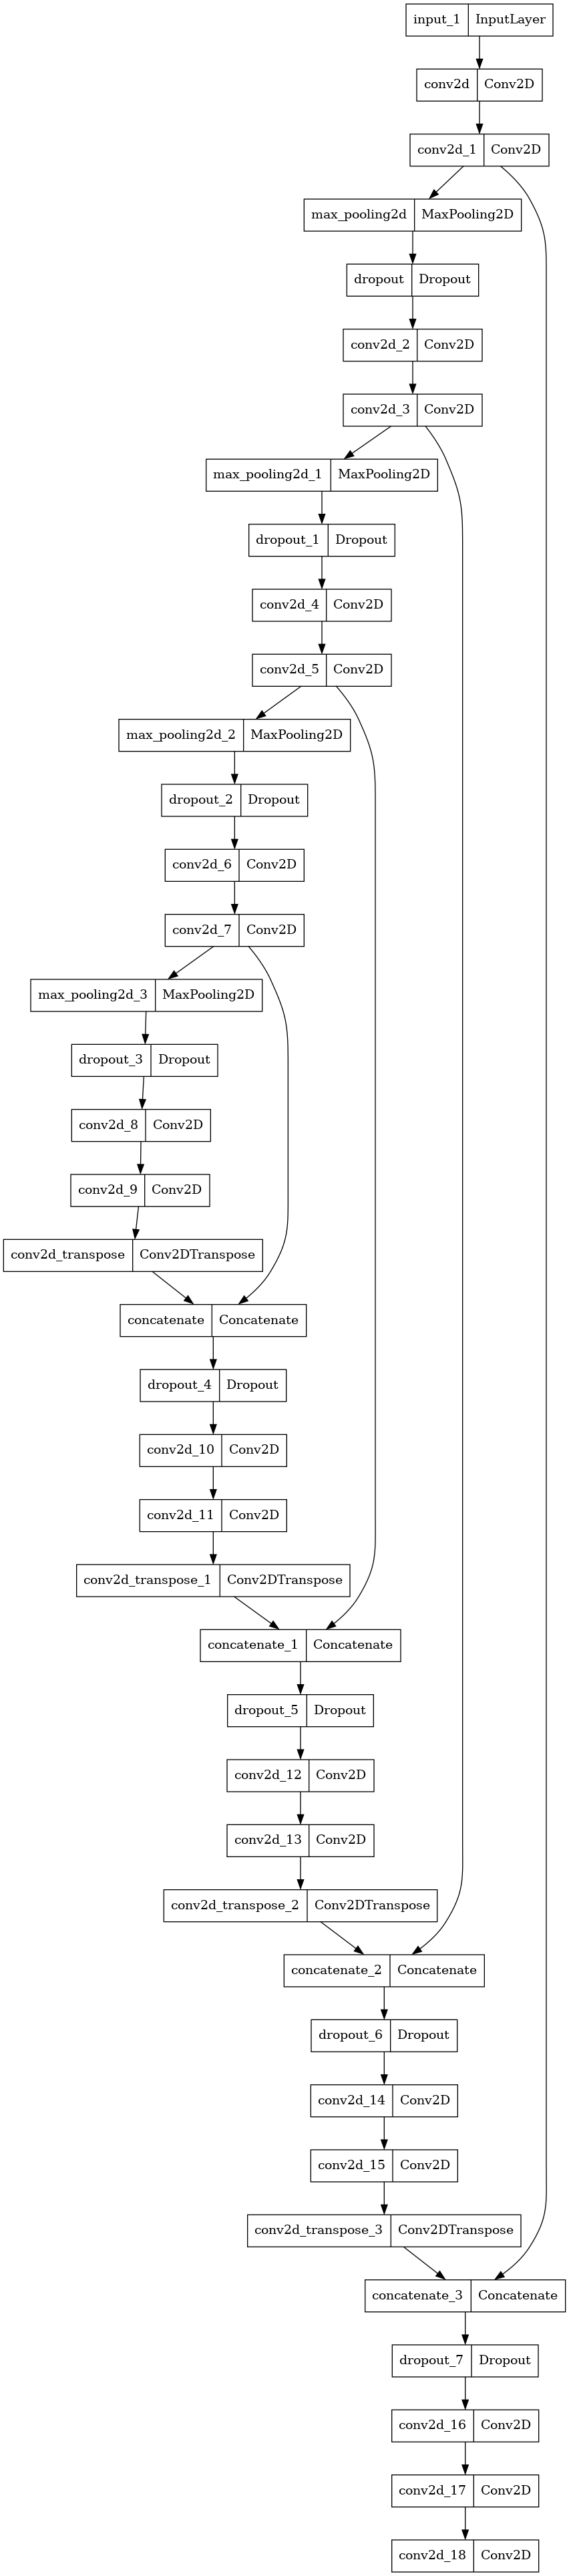

In [120]:
new_model = unet()
opt = Adam(learning_rate=1e-3)
loss = 'categorical_crossentropy'
metrics = ['categorical_accuracy']
epochs = 100
steps_per_epoch = 30
new_model.compile(optimizer=opt, loss=loss, metrics=metrics)
# new_model.summary()
tf.keras.utils.plot_model(new_model) # rankdir="LR"

Due to the imbalanced dataset, as discussed in Section 5, we tried different training set-ups that try to solve this issue. We considered:

1. **No previous preprocesing**: the model is trained with data which was only normalized and resized during its preprocessing. 
2. **Cropping the data**: to balance the number of pixels in each class, we crop images to remove some part of the background during the preprocessing. 
3. **Augmentation**: the training dataset was increased by the use of agmentatqtion data, where the images where randomly flipped or rotated. 
4. **Weight loss**: To compensate the effect of the imbalance data, samples are assigned weights which modify the loss function to penalize the models from predicting the background on an object's pixel.

**1 - No preprocessing** 

In [121]:
if TRAIN_MODELS:
    # Train the model
    history_scratch = new_model.fit(X_train, y_train, 
                        validation_data=(X_val, y_val), 
                        epochs=100, batch_size=32)
else:
    # Download our pretrained version of the model
    reconstructed_model_1 = keras.models.load_model('/kaggle/input/models/model_scratch/model_scratch')
    loss, acc = reconstructed_model_1.evaluate(X_val, y_val)
    # Save loss and acc for discussion later on
    loss_list.append(loss)
    acc_list.append(acc)
    #print(f"The accuracy of the scratch model is {scratch_acc}")
    # Free up memory
    del reconstructed_model_1
    gc.collect()

5/5 [==============================] - 14s 1s/step - loss: 2.1825 - categorical_accuracy: 0.7252


**2 - Augmented dataset**

In [122]:
if TRAIN_MODELS:
    X_train_aug, y_train_aug = augment(X_train, y_train)
    
    # Train the model
    history_scratch = new_model.fit(X_train_aug, y_train_aug, 
                        validation_data=(X_val, y_val), 
                        epochs=100, batch_size=32)
else:
    # Download models from the dataset
    reconstructed_model_aug = keras.models.load_model('/kaggle/input/models/model_scratch_aug/model_scratch_aug/model_scratch_aug')
    loss, acc = reconstructed_model_aug.evaluate(X_val, y_val)
    loss_list.append(loss)
    acc_list.append(acc)
    # Free up memory
    del reconstructed_model_aug
    gc.collect()

5/5 [==============================] - 2s 219ms/step - loss: 2.1864 - categorical_accuracy: 0.7218


**3 - Cropping**

In [123]:
if TRAIN_MODELS:
    # Train the model
    history_scratch = new_model.fit(X_train, y_train, 
                        validation_data=(X_val, y_val), 
                        epochs=100, batch_size=32)
    # Save the obtained weights, to export to Kaggle datasets
    new_model.save('/kaggle/working/model_scratch_crop')
    new_model.save('/downloads/vision_scratch_model_crop')
else:
    # Download models from the dataset
    reconstructed_model_crop = keras.models.load_model('/kaggle/input/models/model_scratch_crop/model_scratch_crop')
    loss, acc = reconstructed_model_crop.evaluate(X_val, y_val)
    loss_list.append(loss)
    acc_list.append(acc)
    # Free up memory
    del reconstructed_model_crop
    gc.collect()

5/5 [==============================] - 2s 207ms/step - loss: 2.0641 - categorical_accuracy: 0.6851


**4 - Weighted loss** The weights are simply obtained from inverting the distribution of the pixel classes that we discussed at the beginning of this notebook, as shown below:

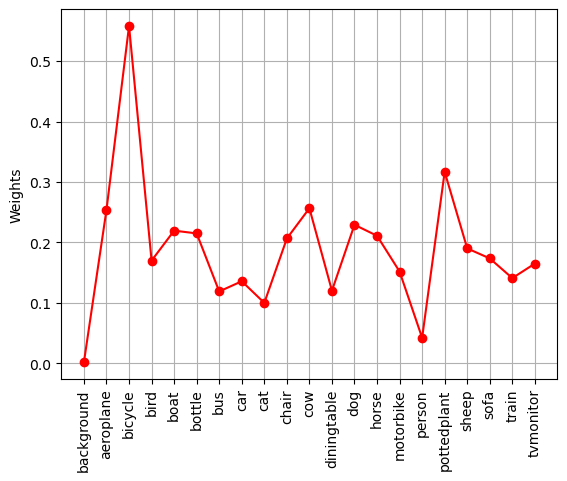

In [124]:
pretrained_weights = 1/seg_distr
pretrained_weights = pretrained_weights/np.linalg.norm(pretrained_weights)
xt = [i for i in range(len(pretrained_weights))]
plt.plot(xt, pretrained_weights, "-o", color="red")
plt.grid()
plt.ylabel("Weights")
plt.xticks(xt, labels=["background"] + labels.tolist(), rotation=90)
plt.show()

The modified loss function is defined below:

**TODO** discuss our idea behind focal loss Source focal loss: https://arxiv.org/pdf/1708.02002v2.pdf

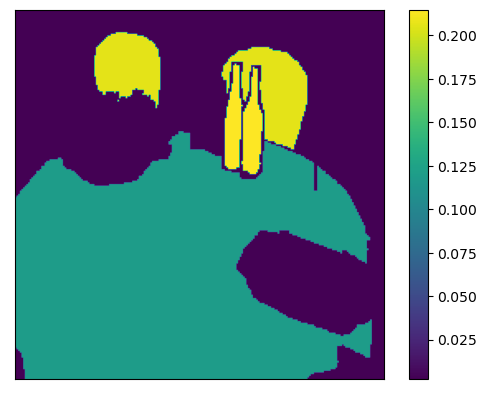

In [125]:
seg = y_train[0]
seg = np.argmax(seg, axis=-1)
weight_mask = tf.gather(pretrained_weights, seg)
plt.imshow(weight_mask)
plt.xticks([])
plt.yticks([])
plt.colorbar()

In [54]:
def weightedLoss(alpha, gamma=2.):
    alpha = np.array(alpha, dtype=np.float32)
    def innerLoss(y_true, y_pred):
        
        # Small number to prevent issues with taking log
        epsilon = K.epsilon()
        # Clip to avoid issues with numerical stuff
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        cross_entropy = -y_true * K.log(y_pred)
        
        # Calculate Focal Loss
        loss = alpha * K.pow(abs(1 - y_pred), gamma) * cross_entropy

        # Compute mean loss in mini_batch
        return K.mean(K.sum(loss, axis=-1))

    return innerLoss

In [55]:
if TRAIN_MODELS:
    new_model.compile(optimizer=opt, loss=weightedLoss(pretrained_weights), metrics=metrics)
    history_scratch = new_model.fit(X_train, y_train, 
                        validation_data=(X_val, y_val), 
                        epochs=500, batch_size=32)
    # Save the obtained weights, to export to Kaggle datasets
    new_model.save('/kaggle/working/model_scratch_weights')
else:
    # Download models from the dataset
    reconstructed_model_w = keras.models.load_model('/kaggle/input/models/model_scratch_weights/model_scratch_weights', compile=False)  #custom_objects={'loss': weightedLoss(pretrained_weights)})
    reconstructed_model_w.compile(optimizer=opt, loss=weightedLoss(pretrained_weights), metrics=metrics)
    loss, acc = reconstructed_model_w.evaluate(X_val, y_val)
    loss_list.append(loss)
    acc_list.append(acc)

NameError: name 'opt' is not defined

It can be notice that the results obtained for the weighted loss are much lower than the ones obtained in the other cases. However, after 500 epochs it can be seen that the model is being able to find patterns in the images, understanding some edges or finding same shapes. The reason why this happend is because of the extremely low accuracy which the model started the training. This low accuracy is the result of the penalty applied to the background layer. This penalty was computed by the use of class_weight function from sklean. And as a consequence, the model start learning progressively from each of the channels, instead of predict always background from the fist iteration as the other models did.

In [ ]:
import zipfile
import os
from IPython.display import FileLink

def zip_dir(directory = os.curdir, file_name = 'directory.zip'):
    """
    zip all the files in a directory
    
    Parameters
    _____
    directory: str
        directory needs to be zipped, defualt is current working directory
        
    file_name: str
        the name of the zipped file (including .zip), default is 'directory.zip'
        
    Returns
    _____
    Creates a hyperlink, which can be used to download the zip file)
    """
    os.chdir(directory)
    zip_ref = zipfile.ZipFile(file_name, mode='w')
    for folder, _, files in os.walk(directory):
        for file in files:
            if file_name in file:
                pass
            else:
                zip_ref.write(os.path.join(folder, file))

    return FileLink(file_name)

### B.1.2 Keras U-Net architecture trained from scratch

Now, we import a U-Net architecture implemented in Keras rather than our self-defined architecture and train it from scratch on our Pascal VOC dataset. 

In [ ]:
if TRAIN_MODELS:
    # Define and train the model
    transfer_model = Unet(classes=num_classes)
    transfer_model.trainable = True
    transfer_model.compile('Adam', 'categorical_crossentropy', ['categorical_accuracy'])
    # Save the model
    transfer_model.save('/kaggle/working/model_scratch_keras')
    history_unet_transfer = transfer_model.fit(X_train, y_train, 
                                          validation_data=(X_val, y_val), 
                                          epochs=95, batch_size=32)
else:
    reconstructed_model_2 = keras.models.load_model('/kaggle/input/models/model_scratch_keras/model_scratch_keras')
    loss, acc = reconstructed_model_2.evaluate(X_val, y_val)
    # Save the performances
    loss_list.append(loss)
    acc_list.append(acc)
    # Free up memory
    del reconstructed_model_2
    gc.collect()

### B.1.3 Transfer learning with Keras U-Net

 Here, we import the U-Net architecture as well as the weights from imagenet. 
 
During training, the training accuracy improves very slowly. Some classes are not identified during testing and only the background is predicted instead. However compared to the model trained from scratch, pixels from one object are not being classified as so many different classes anymore (the output of the softmax is more unimodal). This improvement can be explained by the fact that the weights imported to the model were trained on lots of images such that they have a solid baseline to obtain the segmentation of other shapes. Therefore, they have implicit "knowledge" about patterns like edges or vertices, even some primitive shapes that are common with the Pascal VOC classes, which can help the segmentation of our images. During the training of this model, these initial weights evolve to a more suitable state on this specific dataset through the fine-tuning process, which helps the model against the confusion of classifying several classes to a certain object due to this previous knowledge in the initial weights. Therefore, the new model (after training) is capable to find that a group of pixels are an unique object, although there is still a lot of missclassification around objects and a lot of room for improvement.

In [ ]:
if TRAIN_MODELS:
    # Train the model
    inp = Input(shape=(None, None, num_classes))
    model4 = Unet(backbone_name='resnet34', classes=num_classes, encoder_weights='imagenet')
    model4.compile('Adam', 'categorical_crossentropy', ['categorical_accuracy'])
    history_transfer = model4.fit(X_train, y_train, 
                                  validation_data=(X_val, y_val), 
                                  epochs=105, batch_size=32)
    # Save the weights
    model4.save('/kaggle/working/model_transfer_cat')
    
else:
    reconstructed_model_3 = keras.models.load_model('/kaggle/input/models/model_transfer_cat/model_transfer_cat')
    loss, acc = reconstructed_model_3.evaluate(X_val, y_val)
    loss_list.append(loss)
    acc_list.append(acc)

## B.2 VGG16

Since the above results with the U-Net models was unsatisfactory, we now build a different architecture inspired by [this Github code](https://github.com/farakiko/ImageSegmentationPASCAL/blob/master/Code.ipynb). The model makes use of VGG16, discussed in Section 2 for the classification problem, for the encoder part. We use transfer learning and download the weights from imagenet.  

The architecture was already discussed in the classification section. As mentioned there, the key characteristic of VGG16 is the use of small $3\times 3$ convolutional filters stacked on top of each other, which enables the network to learn complex features from images. The architecture starts with a series of convolutional layers with small filter sizes and a stride of 1. These layers are followed by max pooling layers, which downsample the spatial dimensions of the feature maps, reducing the computational complexity. The pattern of convolutional and pooling layers is repeated several times, allowing the network to capture features at different levels of abstraction (the image of the VGG16 architecture was provided in the classification section). After the convolutional layers, VGG16 has a few fully connected layers. These layers are responsible for learning high-level features and making predictions based on those features. The final layer uses softmax activation to produce class probabilities for image classification tasks.

When it comes to image segmentation, VGG16 can be used as a feature extractor, so we use it in the encoding part of our model. The convolutional layers in VGG16 are capable of learning rich spatial representations of an input image. By removing the fully connected layers and replacing them with appropriate layers for segmentation, such as upsampling or transposed convolutions, VGG16 can be adapted for image segmentation tasks.

The pre-trained VGG16 model, trained on large-scale image classification datasets like ImageNet, has been found to be highly effective in transfer learning. By leveraging the pre-trained weights, the model can be fine-tuned on smaller datasets for specific image segmentation tasks, achieving good performance even with limited training data.

### B.2.4 Transfer learning, VGG16

In [ ]:
# The encoder uses the VGG16
base_model = VGG16(include_top=False, weights='imagenet',input_shape=(224, 224, 3))
base_model.trainable=False

# Add our additional layers on top
vgg_model = Sequential()

vgg_model.add(base_model)
vgg_model.add(Conv2D(4096, (7, 7), activation='tanh',
                padding='same'))
vgg_model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
vgg_model.add(Dropout(0.5))
vgg_model.add((Conv2D(4096, (1, 1), activation='tanh',
                padding='same')))
vgg_model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
vgg_model.add(Dropout(0.5))
vgg_model.add(Conv2D(num_classes,  (1, 1), kernel_initializer='he_normal'))
vgg_model.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))
vgg_model.add(Conv2DTranspose(num_classes, kernel_size=(32, 32),  strides=(32, 32), use_bias=False))
vgg_model.add(Activation('softmax'))

# Plot the architecture:
tf.keras.utils.plot_model(vgg_model)
# vgg_model.summary()

In [ ]:
if TRAIN_MODELS:
    opt = Adam(learning_rate=0.001)
    loss = 'categorical_crossentropy'
    metrics = ['categorical_accuracy']
    epochs = 100
    steps_per_epoch = 80
    vgg_model.compile(optimizer=opt, loss=loss, metrics=metrics)
    history = vgg_model.fit(X_train, y_train, 
                            validation_data=(X_val, y_val), 
                            epochs=110, batch_size=16)
    vgg_model.save('/kaggle/working/model_vgg')
else:
    # Load pretrained model
    reconstructed_model_5 = keras.models.load_model('/kaggle/input/models/model_vgg_2/model_vgg')
    loss, acc = reconstructed_model_5.evaluate(X_val, y_val)
    loss_list.append(loss)
    acc_list.append(acc)
    # Free memory:
    del reconstructed_model_5
    gc.collect()